# Telecom Churn Case Study

### Business Objective
- From the given dataset, perform EDA and modelling and predict the churners
- It is important to predict the churners correctly, technically `True Positives` should he as high as possible and `False Negatives` should be as low as possible
- Evaluate various models based on the results of the right metric
- Propose recommendations to the Operator based on the model results 

Importing all the required libraries

In [1]:
#pip install -U scikit-learn

In [2]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables

Reading and getting first hand view of the data

In [2]:
df=pd.read_csv("telecom_churn_data.csv")

In [3]:
df.head(5)

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
0            9/30/2014  197.385  ...            0        1.0        1.0   
1            9/30/2014   34.047  ...            0        NaN        1.0   
2            9/30/2014  167.690  ...            0        NaN        NaN   
3            9/30/2014  221.338  ...            0        NaN        NaN   
4            9/30/2014  261.636  ...            0        0.0        NaN   

   fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  
0        1.0        NaN   968        30.4         0.0      101.20        3.58  
1        1.0        NaN  1006         0.0         0.0        0.00        0.00  
2        NaN        1.0  1103         0.0         0.0        4.17        0.00  
3        NaN        NaN  2491         0.0         0.0        0.00        0.00  
4        NaN        NaN  1526         0.0         0.0        0.00        0.00  

[5 rows x 226 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


##### Filtering the high values customers based on the business requirement

In [5]:
#Checking the NA trend in these variables as these together decide the total recharge amount of data
df[['total_rech_data_6', 'av_rech_amt_data_6']].isnull().sum()

total_rech_data_6     74846
av_rech_amt_data_6    74846
dtype: int64

In [6]:
df[['total_rech_data_7', 'av_rech_amt_data_7']].isnull().sum()

total_rech_data_7     74428
av_rech_amt_data_7    74428
dtype: int64

- All data points have same number of values missing for the above pair of features
- So imputing it with 0

In [7]:
#Imputing these NAs with 0s
df[['total_rech_data_6', 'av_rech_amt_data_6','total_rech_data_7', 'av_rech_amt_data_7']]=df[['total_rech_data_6', 'av_rech_amt_data_6','total_rech_data_7', 'av_rech_amt_data_7']].fillna(0)
df[['total_rech_data_6', 'av_rech_amt_data_6','total_rech_data_7', 'av_rech_amt_data_7']].isnull().sum()

total_rech_data_6     0
av_rech_amt_data_6    0
total_rech_data_7     0
av_rech_amt_data_7    0
dtype: int64

In [8]:
df['av_rech_amt_6_7']=df.apply(lambda row: (row.av_rech_amt_data_6 * row.total_rech_data_6 + row.total_rech_amt_6)+(row.av_rech_amt_data_7 * row.total_rech_data_7 + row.total_rech_amt_7) / 2, axis=1)

In [9]:
df[['total_rech_data_6', 'av_rech_amt_data_6','total_rech_amt_6','total_rech_data_7', 'av_rech_amt_data_7','total_rech_amt_7', 'av_rech_amt_6_7']].sample(10)

total_rech_data_6  av_rech_amt_data_6  total_rech_amt_6  \
94049                0.0                 0.0               250   
5809                 0.0                 0.0               190   
44443                2.0                50.0                25   
64445                0.0                 0.0               315   
70902                1.0               145.0              1243   
30859                1.0               154.0               344   
57297                0.0                 0.0                90   
88188                0.0                 0.0               266   
38641                0.0                 0.0               101   
14088                0.0                 0.0               590   

       total_rech_data_7  av_rech_amt_data_7  total_rech_amt_7  \
94049                0.0                 0.0              1385   
5809                 0.0                 0.0               400   
44443                9.0               345.0               325   
64445                1.0                25.0               609   
70902                1.0               145.0              1243   
30859                1.0                98.0               178   
57297                0.0                 0.0                70   
88188                0.0                 0.0               160   
38641                1.0               149.0               135   
14088                0.0                 0.0               360   

       av_rech_amt_6_7  
94049            942.5  
5809             390.0  
44443           1840.0  
64445            632.0  
70902           2082.0  
30859            636.0  
57297            125.0  
88188            346.0  
38641            243.0  
14088            770.0

In [10]:
df['av_rech_amt_6_7'].describe()

count     99999.000000
mean        723.527273
std        1311.872857
min           0.000000
25%         190.000000
50%         413.000000
75%         830.000000
max      117965.000000
Name: av_rech_amt_6_7, dtype: float64

Extracting the data points >= 70th percentile of the new feature "av_rech_amt_6_7"

In [11]:
df_high_valued=df[df.av_rech_amt_6_7 >= df.av_rech_amt_6_7.quantile(.70)]
len(df_high_valued)

30014

In [12]:
df_high_valued.sample(10)

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
89393     7002237988        109             0.0             0.0   
19847     7001989920        109             0.0             0.0   
92285     7000089669        109             0.0             0.0   
39134     7002021589        109             0.0             0.0   
18772     7000225442        109             0.0             0.0   
60752     7001881207        109             0.0             0.0   
35638     7000244996        109             0.0             0.0   
83122     7001425755        109             0.0             0.0   
57996     7002402524        109             0.0             0.0   
94332     7000669892        109             0.0             0.0   

       loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7  \
89393             0.0            6/30/2014            7/31/2014   
19847             0.0            6/30/2014            7/31/2014   
92285             0.0            6/30/2014            7/31/2014   
39134             0.0            6/30/2014            7/31/2014   
18772             0.0            6/30/2014            7/31/2014   
60752             0.0            6/30/2014            7/31/2014   
35638             0.0            6/30/2014            7/31/2014   
83122             0.0            6/30/2014            7/31/2014   
57996             0.0            6/30/2014            7/31/2014   
94332             0.0            6/30/2014            7/31/2014   

      last_date_of_month_8 last_date_of_month_9    arpu_6  ...  fb_user_6  \
89393            8/31/2014            9/30/2014   213.810  ...        1.0   
19847            8/31/2014            9/30/2014   617.404  ...        1.0   
92285            8/31/2014            9/30/2014   172.891  ...        1.0   
39134            8/31/2014            9/30/2014   391.491  ...        NaN   
18772            8/31/2014            9/30/2014   563.959  ...        1.0   
60752            8/31/2014            9/30/2014  1696.770  ...        0.0   
35638            8/31/2014            9/30/2014   181.916  ...        1.0   
83122            8/31/2014            9/30/2014   151.597  ...        1.0   
57996            8/31/2014            9/30/2014   394.342  ...        1.0   
94332            8/31/2014            9/30/2014   985.681  ...        NaN   

       fb_user_7  fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  \
89393        1.0        1.0        NaN   571        0.00        0.00   
19847        1.0        1.0        1.0   942        0.00        0.00   
92285        1.0        1.0        1.0   289       90.98        0.00   
39134        NaN        NaN        NaN   571        0.00        0.00   
18772        1.0        1.0        1.0  1282      174.16      199.27   
60752        0.0        0.0        0.0   973        0.00        0.00   
35638        1.0        NaN        1.0   584       97.38        0.00   
83122        1.0        1.0        1.0  2222      683.20      521.26   
57996        1.0        NaN        1.0   224        0.00        0.00   
94332        NaN        NaN        NaN   996        0.00        0.00   

       jun_vbc_3g  sep_vbc_3g  av_rech_amt_6_7  
89393        0.00         0.0            959.0  
19847        0.00         0.0           1351.0  
92285        0.00         0.0            791.5  
39134        0.00         0.0            749.5  
18772       63.20         0.0           2882.0  
60752        0.00         0.0           3258.0  
35638      140.61         0.0           1254.0  
83122      184.14         0.0           1681.5  
57996        0.00         0.0           1074.0  
94332        0.00         0.0           1659.0  

[10 rows x 227 columns]

#### Tag the churners and remove the 9th month attributes

In [13]:
df_high_valued['churn']=df_high_valued.apply(lambda row: 1 if row.total_ic_mou_9 + row.total_og_mou_9 + row.vol_2g_mb_9 + row.vol_3g_mb_9 == 0 else 0, axis = 1)

In [14]:
len(df_high_valued)

30014

### Percentage of churners in the dataset

In [15]:
round(100*(df_high_valued['churn'].sum()/len(df_high_valued)),2)

8.8

Since the churners are quite low, some technique will have to be employed to address class imbalance

In [16]:
df_high_valued.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'fb_user_7', 'fb_user_8', 'fb_user_9', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g', 'av_rech_amt_6_7', 'churn'],
      dtype='object', length=228)

Identifying the 9th month attibutes and removing those

In [17]:
col_to_be_removed=[]
for col in df_high_valued.columns:
    if col.find('_9') != -1:
        col_to_be_removed.append(col)
        
df_high_valued.drop(col_to_be_removed, axis = 1, inplace=True)

In [18]:
len(col_to_be_removed)

54

In [19]:
len(df_high_valued.columns)

174

In [20]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [21]:
df_high_valued.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30014 entries, 0 to 99998
Columns: 174 entries, mobile_number to churn
dtypes: float64(137), int64(28), object(9)
memory usage: 40.1+ MB


In [22]:
round(100*df_high_valued.isnull().sum()/len(df_high_valued),2)

mobile_number                0.00
circle_id                    0.00
loc_og_t2o_mou               0.79
std_og_t2o_mou               0.79
loc_ic_t2o_mou               0.79
last_date_of_month_6         0.00
last_date_of_month_7         0.16
last_date_of_month_8         0.67
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
onnet_mou_6                  1.61
onnet_mou_7                  2.15
onnet_mou_8                  4.53
offnet_mou_6                 1.61
offnet_mou_7                 2.15
offnet_mou_8                 4.53
roam_ic_mou_6                1.61
roam_ic_mou_7                2.15
roam_ic_mou_8                4.53
roam_og_mou_6                1.61
roam_og_mou_7                2.15
roam_og_mou_8                4.53
loc_og_t2t_mou_6             1.61
loc_og_t2t_mou_7             2.15
loc_og_t2t_mou_8             4.53
loc_og_t2m_mou_6             1.61
loc_og_t2m_mou_7             2.15
loc_og_t2m_mou_8             4.53
loc_og_t2f_mou

#### Some study done on incoming and outgoing call features and the inferences are below
##### Total outgoing and incoming call features are found to be the sum of many of the individual categories like mentioned below
- total_og_mou = loc_og_mou + std_og_mou + isd_og_mou + spl_og_mou + og_others_6
    - Above statement is true for all the data points
    - total_og_mou has no missing values and this column alone could represent all the other columns mentioned above


- loc_og_mou_6/7/8 - Sum of all local outgoing calls
- loc_og_mou = loc_og_t2f_mou + loc_og_t2m_mou + loc_og_t2t_mou
- std_og_mou = std_og_t2t_mou + std_og_t2m_mou + std_og_t2f_mou
- total_og_mou = loc_og_mou + std_og_mou + isd_og_mou + spl_og_mou + og_others
- std_og_t2c_mou could be removed
<br>
- total_og_mou_6 = og_others_6 + spl_og_mou_6 + isd_og_mou_6 + std_og_mou_6 + loc_og_mou_6

### Below activity is done to verify statistically the above inferences
- New columns are created for the difference of total calls and sum of other columns that are inferred to be making up the total call features
- Statistical information of all these columns are then studied to see if the sum of individual call categories are still the same way as mentioend above

In [23]:
df_high_valued['diff_loc_og_mou_6']= (df_high_valued['loc_og_t2f_mou_6'] + df_high_valued['loc_og_t2m_mou_6'] + df_high_valued['loc_og_t2t_mou_6']) - df_high_valued['loc_og_mou_6']
df_high_valued['diff_loc_og_mou_7']= (df_high_valued['loc_og_t2f_mou_7'] + df_high_valued['loc_og_t2m_mou_7'] + df_high_valued['loc_og_t2t_mou_7']) - df_high_valued['loc_og_mou_7']
df_high_valued['diff_loc_og_mou_8']= (df_high_valued['loc_og_t2f_mou_8'] + df_high_valued['loc_og_t2m_mou_8'] + df_high_valued['loc_og_t2t_mou_8']) - df_high_valued['loc_og_mou_8']

df_high_valued['diff_std_og_mou_6'] = (df_high_valued['std_og_t2t_mou_6'] + df_high_valued['std_og_t2m_mou_6'] + df_high_valued['std_og_t2f_mou_6']) - df_high_valued['std_og_mou_6']
df_high_valued['diff_std_og_mou_7'] = (df_high_valued['std_og_t2t_mou_7'] + df_high_valued['std_og_t2m_mou_7'] + df_high_valued['std_og_t2f_mou_7']) - df_high_valued['std_og_mou_7']
df_high_valued['diff_std_og_mou_8'] = (df_high_valued['std_og_t2t_mou_8'] + df_high_valued['std_og_t2m_mou_8'] + df_high_valued['std_og_t2f_mou_8']) - df_high_valued['std_og_mou_8']

df_high_valued['diff_total_og_mou_6'] = (df_high_valued['og_others_6'] + df_high_valued['spl_og_mou_6'] + df_high_valued['isd_og_mou_6'] + df_high_valued['std_og_mou_6'] + df_high_valued['loc_og_mou_6']) - df_high_valued['total_og_mou_6']
df_high_valued['diff_total_og_mou_7'] = (df_high_valued['og_others_7'] + df_high_valued['spl_og_mou_7'] + df_high_valued['isd_og_mou_7'] + df_high_valued['std_og_mou_7'] + df_high_valued['loc_og_mou_7']) - df_high_valued['total_og_mou_7']
df_high_valued['diff_total_og_mou_8'] = (df_high_valued['og_others_8'] + df_high_valued['spl_og_mou_8'] + df_high_valued['isd_og_mou_8'] + df_high_valued['std_og_mou_8'] + df_high_valued['loc_og_mou_8']) - df_high_valued['total_og_mou_8']

#Incoming
df_high_valued['diff_loc_ic_mou_6']= (df_high_valued['loc_ic_t2t_mou_6'] + df_high_valued['loc_ic_t2m_mou_6'] + df_high_valued['loc_ic_t2f_mou_6']) - df_high_valued['loc_ic_mou_6']
df_high_valued['diff_loc_ic_mou_7']= (df_high_valued['loc_ic_t2t_mou_7'] + df_high_valued['loc_ic_t2m_mou_7'] + df_high_valued['loc_ic_t2f_mou_7']) - df_high_valued['loc_ic_mou_7']
df_high_valued['diff_loc_ic_mou_8']= (df_high_valued['loc_ic_t2t_mou_8'] + df_high_valued['loc_ic_t2m_mou_8'] + df_high_valued['loc_ic_t2f_mou_8']) - df_high_valued['loc_ic_mou_8']

df_high_valued['diff_std_ic_mou_6']= (df_high_valued['std_ic_t2t_mou_6'] + df_high_valued['std_ic_t2m_mou_6'] + df_high_valued['std_ic_t2f_mou_6']) - df_high_valued['std_ic_mou_6']
df_high_valued['diff_std_ic_mou_7']= (df_high_valued['std_ic_t2t_mou_7'] + df_high_valued['std_ic_t2m_mou_7'] + df_high_valued['std_ic_t2f_mou_7']) - df_high_valued['std_ic_mou_7']
df_high_valued['diff_std_ic_mou_8']= (df_high_valued['std_ic_t2t_mou_8'] + df_high_valued['std_ic_t2m_mou_8'] + df_high_valued['std_ic_t2f_mou_8']) - df_high_valued['std_ic_mou_8']

df_high_valued['diff_total_ic_mou_6'] = (df_high_valued['ic_others_6'] + df_high_valued['spl_ic_mou_6'] + df_high_valued['isd_ic_mou_6'] + df_high_valued['std_ic_mou_6'] + df_high_valued['loc_ic_mou_6']) - df_high_valued['total_ic_mou_6']
df_high_valued['diff_total_ic_mou_7'] = (df_high_valued['ic_others_7'] + df_high_valued['spl_ic_mou_7'] + df_high_valued['isd_ic_mou_7'] + df_high_valued['std_ic_mou_7'] + df_high_valued['loc_ic_mou_7']) - df_high_valued['total_ic_mou_7']
df_high_valued['diff_total_ic_mou_8'] = (df_high_valued['ic_others_8'] + df_high_valued['spl_ic_mou_8'] + df_high_valued['isd_ic_mou_8'] + df_high_valued['std_ic_mou_8'] + df_high_valued['loc_ic_mou_8']) - df_high_valued['total_ic_mou_8']


In [24]:
newColumns = ['diff_loc_og_mou_6','diff_loc_og_mou_7','diff_loc_og_mou_8',
              'diff_std_og_mou_6','diff_std_og_mou_7','diff_std_og_mou_8',
              'diff_total_og_mou_6','diff_total_og_mou_7','diff_total_og_mou_8',
              'diff_loc_ic_mou_6','diff_loc_ic_mou_7','diff_loc_ic_mou_8',
              'diff_std_ic_mou_6','diff_std_ic_mou_7','diff_std_ic_mou_8',
              'diff_total_ic_mou_6','diff_total_ic_mou_7','diff_total_ic_mou_8']
df_high_valued[newColumns].describe()

diff_loc_og_mou_6  diff_loc_og_mou_7  diff_loc_og_mou_8  \
count       2.953200e+04       2.936800e+04       2.865500e+04   
mean       -8.466409e-03      -8.449333e-03      -8.149014e-03   
std         6.477975e-03       6.493781e-03       6.583735e-03   
min        -2.000000e-02      -2.000000e-02      -2.000000e-02   
25%        -1.000000e-02      -1.000000e-02      -1.000000e-02   
50%        -1.000000e-02      -1.000000e-02      -1.000000e-02   
75%         0.000000e+00       0.000000e+00       0.000000e+00   
max         9.094947e-13       4.547474e-13       4.547474e-13   

       diff_std_og_mou_6  diff_std_og_mou_7  diff_std_og_mou_8  \
count       2.953200e+04       2.936800e+04       2.865500e+04   
mean       -3.846336e-03      -3.717652e-03      -3.431513e-03   
std         5.241112e-03       5.168548e-03       5.094484e-03   
min        -2.000000e-02      -2.000000e-02      -2.000000e-02   
25%        -1.000000e-02      -1.000000e-02      -1.000000e-02   
50%         0.000000e+00       0.000000e+00       0.000000e+00   
75%         0.000000e+00       0.000000e+00       0.000000e+00   
max         9.094947e-13       1.818989e-12       9.094947e-13   

       diff_total_og_mou_6  diff_total_og_mou_7  diff_total_og_mou_8  \
count         2.953200e+04         2.936800e+04         2.865500e+04   
mean         -9.285182e-03        -8.022678e-03        -7.772117e-03   
std           7.724845e-03         6.671969e-03         6.742302e-03   
min          -4.000000e-02        -3.000000e-02        -3.000000e-02   
25%          -1.000000e-02        -1.000000e-02        -1.000000e-02   
50%          -1.000000e-02        -1.000000e-02        -1.000000e-02   
75%           0.000000e+00         0.000000e+00         0.000000e+00   
max           4.547474e-13         1.818989e-12         4.547474e-13   

       diff_loc_ic_mou_6  diff_loc_ic_mou_7  diff_loc_ic_mou_8  \
count       2.953200e+04       2.936800e+04       2.865500e+04   
mean       -9.879791e-03      -9.846091e-03      -9.686268e-03   
std         6.426094e-03       6.467829e-03       6.593946e-03   
min        -2.000000e-02      -2.000000e-02      -2.000000e-02   
25%        -1.000000e-02      -1.000000e-02      -1.000000e-02   
50%        -1.000000e-02      -1.000000e-02      -1.000000e-02   
75%        -1.000000e-02      -1.000000e-02      -1.000000e-02   
max         4.547474e-13       4.547474e-13       4.547474e-13   

       diff_std_ic_mou_6  diff_std_ic_mou_7  diff_std_ic_mou_8  \
count       2.953200e+04       2.936800e+04       2.865500e+04   
mean       -3.689218e-03      -3.671683e-03      -3.478625e-03   
std         5.347811e-03       5.407060e-03       5.294597e-03   
min        -2.000000e-02      -2.000000e-02      -2.000000e-02   
25%        -1.000000e-02      -1.000000e-02      -1.000000e-02   
50%         0.000000e+00       0.000000e+00       0.000000e+00   
75%         0.000000e+00       0.000000e+00       0.000000e+00   
max         4.547474e-13       9.094947e-13       4.547474e-13   

       diff_total_ic_mou_6  diff_total_ic_mou_7  diff_total_ic_mou_8  
count         2.953200e+04         2.936800e+04         2.865500e+04  
mean         -8.341460e-03        -7.618156e-03        -7.565521e-03  
std           7.180874e-03         6.718792e-03         6.820011e-03  
min          -4.000000e-02        -4.000000e-02        -4.000000e-02  
25%          -1.000000e-02        -1.000000e-02        -1.000000e-02  
50%          -1.000000e-02        -1.000000e-02        -1.000000e-02  
75%           0.000000e+00         0.000000e+00         0.000000e+00  
max           9.094947e-13         4.547474e-13         9.094947e-13

- Min and max values of all these derived columns are almost 0 or negligible
- This confirms the fact that few variables put together make up for the total call feature in incoming and outgoing
- Since total call feature is already explaining these variables, removing the other features

In [25]:
to_be_dropped=[
'loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6','std_og_mou_6','isd_og_mou_6','spl_og_mou_6','og_others_6',
'loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7','std_og_mou_7','isd_og_mou_7','spl_og_mou_7','og_others_7',
'loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8','std_og_mou_8','isd_og_mou_8','spl_og_mou_8','og_others_8',
'loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','loc_ic_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6','std_ic_t2o_mou_6','std_ic_mou_6','spl_ic_mou_6', 'isd_ic_mou_6','ic_others_6',
'loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','loc_ic_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7','std_ic_t2o_mou_7','std_ic_mou_7','spl_ic_mou_7', 'isd_ic_mou_7','ic_others_7',
'loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','loc_ic_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8','std_ic_t2o_mou_8','std_ic_mou_8','spl_ic_mou_8', 'isd_ic_mou_8','ic_others_8']
to_be_dropped.extend(newColumns)

In [26]:
len(to_be_dropped)

87

In [27]:
df_high_valued.nunique()

mobile_number               30014
circle_id                       1
loc_og_t2o_mou                  1
std_og_t2o_mou                  1
loc_ic_t2o_mou                  1
last_date_of_month_6            1
last_date_of_month_7            1
last_date_of_month_8            1
arpu_6                      29178
arpu_7                      28945
arpu_8                      27844
onnet_mou_6                 17170
onnet_mou_7                 16769
onnet_mou_8                 15651
offnet_mou_6                21453
offnet_mou_7                21000
offnet_mou_8                19875
roam_ic_mou_6                4062
roam_ic_mou_7                3405
roam_ic_mou_8                3430
roam_og_mou_6                4795
roam_og_mou_7                4024
roam_og_mou_8                4007
loc_og_t2t_mou_6            10502
loc_og_t2t_mou_7            10316
loc_og_t2t_mou_8             9994
loc_og_t2m_mou_6            15770
loc_og_t2m_mou_7            15528
loc_og_t2m_mou_8            15034
loc_og_t2f_mou

Also removing the features which does not have any variance

In [28]:
#Also dropping the numeric columns with only one unique value
to_be_dropped.extend(['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou', 'std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8'])
len(to_be_dropped)

96

In [29]:
df_high_valued.drop(to_be_dropped, axis=1, inplace=True)
df_high_valued.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30014 entries, 0 to 99998
Data columns (total 99 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mobile_number             30014 non-null  int64  
 1   circle_id                 30014 non-null  int64  
 2   last_date_of_month_6      30014 non-null  object 
 3   last_date_of_month_7      29967 non-null  object 
 4   last_date_of_month_8      29813 non-null  object 
 5   arpu_6                    30014 non-null  float64
 6   arpu_7                    30014 non-null  float64
 7   arpu_8                    30014 non-null  float64
 8   onnet_mou_6               29532 non-null  float64
 9   onnet_mou_7               29368 non-null  float64
 10  onnet_mou_8               28655 non-null  float64
 11  offnet_mou_6              29532 non-null  float64
 12  offnet_mou_7              29368 non-null  float64
 13  offnet_mou_8              28655 non-null  float64
 14  roam_i

## Missing value treatment and Deriving new Features
##### Converting date columns to appropriate type

In [30]:
df_high_valued[["last_date_of_month_6", "last_date_of_month_7", "last_date_of_month_8","date_of_last_rech_6","date_of_last_rech_7","date_of_last_rech_8","date_of_last_rech_data_6","date_of_last_rech_data_7","date_of_last_rech_data_8"]] = df_high_valued[["last_date_of_month_6", "last_date_of_month_7", "last_date_of_month_8","date_of_last_rech_6","date_of_last_rech_7","date_of_last_rech_8","date_of_last_rech_data_6","date_of_last_rech_data_7","date_of_last_rech_data_8"]].apply(pd.to_datetime)

In [31]:
df_high_valued.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30014 entries, 0 to 99998
Data columns (total 99 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   mobile_number             30014 non-null  int64         
 1   circle_id                 30014 non-null  int64         
 2   last_date_of_month_6      30014 non-null  datetime64[ns]
 3   last_date_of_month_7      29967 non-null  datetime64[ns]
 4   last_date_of_month_8      29813 non-null  datetime64[ns]
 5   arpu_6                    30014 non-null  float64       
 6   arpu_7                    30014 non-null  float64       
 7   arpu_8                    30014 non-null  float64       
 8   onnet_mou_6               29532 non-null  float64       
 9   onnet_mou_7               29368 non-null  float64       
 10  onnet_mou_8               28655 non-null  float64       
 11  offnet_mou_6              29532 non-null  float64       
 12  offnet_mou_7      

In [32]:
round(100*df_high_valued.isnull().sum()/len(df_high_valued),2)

mobile_number                0.00
circle_id                    0.00
last_date_of_month_6         0.00
last_date_of_month_7         0.16
last_date_of_month_8         0.67
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
onnet_mou_6                  1.61
onnet_mou_7                  2.15
onnet_mou_8                  4.53
offnet_mou_6                 1.61
offnet_mou_7                 2.15
offnet_mou_8                 4.53
roam_ic_mou_6                1.61
roam_ic_mou_7                2.15
roam_ic_mou_8                4.53
roam_og_mou_6                1.61
roam_og_mou_7                2.15
roam_og_mou_8                4.53
loc_og_t2c_mou_6             1.61
loc_og_t2c_mou_7             2.15
loc_og_t2c_mou_8             4.53
total_og_mou_6               0.00
total_og_mou_7               0.00
total_og_mou_8               0.00
total_ic_mou_6               0.00
total_ic_mou_7               0.00
total_ic_mou_8               0.00
total_rech_num

In [33]:
df_high_valued.sample(10)

mobile_number  circle_id last_date_of_month_6 last_date_of_month_7  \
77696     7001035804        109           2014-06-30           2014-07-31   
15153     7001588737        109           2014-06-30           2014-07-31   
74749     7002054507        109           2014-06-30           2014-07-31   
93188     7000501815        109           2014-06-30           2014-07-31   
20378     7000863605        109           2014-06-30           2014-07-31   
74384     7000596791        109           2014-06-30           2014-07-31   
43168     7000129371        109           2014-06-30           2014-07-31   
10492     7001743049        109           2014-06-30           2014-07-31   
73448     7002120493        109           2014-06-30           2014-07-31   
92642     7002107692        109           2014-06-30           2014-07-31   

      last_date_of_month_8    arpu_6    arpu_7    arpu_8  onnet_mou_6  \
77696           2014-08-31   660.245  1368.177  1687.386        15.31   
15153           2014-08-31   421.439   243.223   442.642       264.58   
74749           2014-08-31   550.394   447.329   395.931        37.28   
93188           2014-08-31   234.505   241.315    49.660          NaN   
20378           2014-08-31   608.472   736.904   386.921       133.53   
74384           2014-08-31   142.001   189.176   142.314        35.89   
43168           2014-08-31   245.765   148.806   154.134         3.49   
10492           2014-08-31  1195.257   924.709  1282.668       516.34   
73448           2014-08-31   350.406   451.700   472.354        77.06   
92642           2014-08-31   133.316   145.723   162.525         0.83   

       onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
77696         1.60         0.11          6.13          0.53          0.64   
15153        43.13       112.26        197.71         83.98        139.83   
74749        51.46        22.46       1212.04        871.93        734.83   
93188         0.00          NaN           NaN          0.00           NaN   
20378       132.08       124.96        575.39        719.83        513.63   
74384        63.96        28.88         84.63         36.99         30.91   
43168         4.08        17.66         93.13        110.13        118.99   
10492       591.88       681.64        861.69        644.56       1197.73   
73448        82.11        38.99        105.06        164.49        218.89   
92642         0.00         6.71          2.19          0.06          5.31   

       roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
77696           0.00           0.00           0.00           0.00   
15153           0.00           0.00           0.00           0.00   
74749           0.00           0.00           0.00           0.00   
93188            NaN           0.00            NaN            NaN   
20378           0.00           0.00           0.00           0.00   
74384           0.00           0.00           0.00           0.00   
43168           0.00           0.00           0.00           0.00   
10492         850.38         534.83          72.86        1378.04   
73448           3.86           0.00          13.44          23.09   
92642           0.00           0.00           0.00           0.00   

       roam_og_mou_7  roam_og_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  \
77696           0.00           0.00              0.00              0.00   
15153           0.00           0.00              0.00              0.00   
74749           0.00           0.00              0.00              0.00   
93188           0.01            NaN               NaN              0.01   
20378           0.00           0.00              0.00              0.00   
74384           0.00           0.00              0.00              0.00   
43168           0.00           0.00              0.00              0.00   
10492        1236.44         337.01              2.31              8.56   
73448           0.00          10.79              0.00              0.00 

##### Imputing the last date of the month for July and August

In [34]:
df_high_valued.last_date_of_month_7.fillna(df_high_valued.iloc[0,3], inplace=True)
df_high_valued.last_date_of_month_8.fillna(df_high_valued.iloc[0,4], inplace=True)

In [35]:
print(df_high_valued.last_date_of_month_6.value_counts())
print(df_high_valued.last_date_of_month_7.value_counts())
print(df_high_valued.last_date_of_month_8.value_counts())

2014-06-30    30014
Name: last_date_of_month_6, dtype: int64
2014-07-31    30014
Name: last_date_of_month_7, dtype: int64
2014-08-31    30014
Name: last_date_of_month_8, dtype: int64


- onnet_mou and offnet_mou according to description is all kinds of calls within the same and outside of network
- this is somehow captured in total incoming, total outgoing etc
- Hence these parameters could be removed

In [36]:
df_high_valued.drop(['onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7','offnet_mou_8'], axis=1, inplace=True)
df_high_valued.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30014 entries, 0 to 99998
Data columns (total 93 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   mobile_number             30014 non-null  int64         
 1   circle_id                 30014 non-null  int64         
 2   last_date_of_month_6      30014 non-null  datetime64[ns]
 3   last_date_of_month_7      30014 non-null  datetime64[ns]
 4   last_date_of_month_8      30014 non-null  datetime64[ns]
 5   arpu_6                    30014 non-null  float64       
 6   arpu_7                    30014 non-null  float64       
 7   arpu_8                    30014 non-null  float64       
 8   roam_ic_mou_6             29532 non-null  float64       
 9   roam_ic_mou_7             29368 non-null  float64       
 10  roam_ic_mou_8             28655 non-null  float64       
 11  roam_og_mou_6             29532 non-null  float64       
 12  roam_og_mou_7     

In [37]:
round(100*df_high_valued.isnull().sum()/len(df_high_valued),2)

mobile_number                0.00
circle_id                    0.00
last_date_of_month_6         0.00
last_date_of_month_7         0.00
last_date_of_month_8         0.00
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
roam_ic_mou_6                1.61
roam_ic_mou_7                2.15
roam_ic_mou_8                4.53
roam_og_mou_6                1.61
roam_og_mou_7                2.15
roam_og_mou_8                4.53
loc_og_t2c_mou_6             1.61
loc_og_t2c_mou_7             2.15
loc_og_t2c_mou_8             4.53
total_og_mou_6               0.00
total_og_mou_7               0.00
total_og_mou_8               0.00
total_ic_mou_6               0.00
total_ic_mou_7               0.00
total_ic_mou_8               0.00
total_rech_num_6             0.00
total_rech_num_7             0.00
total_rech_num_8             0.00
total_rech_amt_6             0.00
total_rech_amt_7             0.00
total_rech_amt_8             0.00
max_rech_amt_6

- Imputing the following features with 0 as it will fine to assume that no calls of the below category has been made if the values are missing
    - roam_ic_mou_6
    - roam_ic_mou_7
    - roam_ic_mou_8
    - roam_og_mou_6
    - roam_og_mou_7
    - roam_og_mou_8
    - loc_og_t2c_mou_6
    - loc_og_t2c_mou_7
    - loc_og_t2c_mou_8
    - std_og_t2c_mou_6
    - std_og_t2c_mou_7
    - std_og_t2c_mou_8
   

In [38]:
to_be_zero_imputed_columns = ['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','roam_og_mou_6','roam_og_mou_7','roam_og_mou_8','loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8']
df_high_valued[to_be_zero_imputed_columns] = df_high_valued[to_be_zero_imputed_columns].fillna(0)

In [39]:
round(100*df_high_valued.isnull().sum()/len(df_high_valued),2)

mobile_number                0.00
circle_id                    0.00
last_date_of_month_6         0.00
last_date_of_month_7         0.00
last_date_of_month_8         0.00
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
roam_ic_mou_6                0.00
roam_ic_mou_7                0.00
roam_ic_mou_8                0.00
roam_og_mou_6                0.00
roam_og_mou_7                0.00
roam_og_mou_8                0.00
loc_og_t2c_mou_6             0.00
loc_og_t2c_mou_7             0.00
loc_og_t2c_mou_8             0.00
total_og_mou_6               0.00
total_og_mou_7               0.00
total_og_mou_8               0.00
total_ic_mou_6               0.00
total_ic_mou_7               0.00
total_ic_mou_8               0.00
total_rech_num_6             0.00
total_rech_num_7             0.00
total_rech_num_8             0.00
total_rech_amt_6             0.00
total_rech_amt_7             0.00
total_rech_amt_8             0.00
max_rech_amt_6

In [40]:
print(df_high_valued.date_of_last_rech_6.value_counts())
print(df_high_valued.date_of_last_rech_7.value_counts())
print(df_high_valued.date_of_last_rech_8.value_counts())

2014-06-30    8443
2014-06-29    5435
2014-06-28    3708
2014-06-27    3160
2014-06-26    1830
2014-06-25    1345
2014-06-24    1046
2014-06-23     708
2014-06-21     647
2014-06-22     526
2014-06-14     489
2014-06-17     414
2014-06-20     394
2014-06-19     377
2014-06-18     374
2014-06-16     201
2014-06-13     190
2014-06-12     184
2014-06-15     140
2014-06-11      79
2014-06-08      62
2014-06-10      44
2014-06-07      42
2014-06-05      27
2014-06-09      27
2014-06-03      25
2014-06-06      22
2014-06-04      19
2014-06-02      12
2014-06-01       8
Name: date_of_last_rech_6, dtype: int64
2014-07-31    7374
2014-07-30    5175
2014-07-29    3420
2014-07-28    2725
2014-07-25    2011
2014-07-27    1755
2014-07-26    1616
2014-07-24     956
2014-07-22     680
2014-07-15     648
2014-07-23     595
2014-07-16     504
2014-07-20     437
2014-07-21     393
2014-07-19     369
2014-07-17     317
2014-07-18     262
2014-07-09      89
2014-07-10      88
2014-07-14      78
2014-07-12

Imputing the columns "date_of_last_rech" for all 3 months with their respective modes

In [41]:
df_high_valued.date_of_last_rech_6.fillna(df_high_valued.date_of_last_rech_6.mode()[0], inplace=True)
df_high_valued.date_of_last_rech_7.fillna(df_high_valued.date_of_last_rech_7.mode()[0], inplace=True)
df_high_valued.date_of_last_rech_8.fillna(df_high_valued.date_of_last_rech_8.mode()[0], inplace=True)
print(df_high_valued.date_of_last_rech_6.value_counts())
print(df_high_valued.date_of_last_rech_7.value_counts())
print(df_high_valued.date_of_last_rech_8.value_counts())

2014-06-30    8479
2014-06-29    5435
2014-06-28    3708
2014-06-27    3160
2014-06-26    1830
2014-06-25    1345
2014-06-24    1046
2014-06-23     708
2014-06-21     647
2014-06-22     526
2014-06-14     489
2014-06-17     414
2014-06-20     394
2014-06-19     377
2014-06-18     374
2014-06-16     201
2014-06-13     190
2014-06-12     184
2014-06-15     140
2014-06-11      79
2014-06-08      62
2014-06-10      44
2014-06-07      42
2014-06-05      27
2014-06-09      27
2014-06-03      25
2014-06-06      22
2014-06-04      19
2014-06-02      12
2014-06-01       8
Name: date_of_last_rech_6, dtype: int64
2014-07-31    7537
2014-07-30    5175
2014-07-29    3420
2014-07-28    2725
2014-07-25    2011
2014-07-27    1755
2014-07-26    1616
2014-07-24     956
2014-07-22     680
2014-07-15     648
2014-07-23     595
2014-07-16     504
2014-07-20     437
2014-07-21     393
2014-07-19     369
2014-07-17     317
2014-07-18     262
2014-07-09      89
2014-07-10      88
2014-07-14      78
2014-07-12

In [42]:
df_high_valued.date_of_last_rech_data_6.isnull().sum()

12958

In [43]:
round(100*df_high_valued.isnull().sum()/len(df_high_valued),2)

mobile_number                0.00
circle_id                    0.00
last_date_of_month_6         0.00
last_date_of_month_7         0.00
last_date_of_month_8         0.00
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
roam_ic_mou_6                0.00
roam_ic_mou_7                0.00
roam_ic_mou_8                0.00
roam_og_mou_6                0.00
roam_og_mou_7                0.00
roam_og_mou_8                0.00
loc_og_t2c_mou_6             0.00
loc_og_t2c_mou_7             0.00
loc_og_t2c_mou_8             0.00
total_og_mou_6               0.00
total_og_mou_7               0.00
total_og_mou_8               0.00
total_ic_mou_6               0.00
total_ic_mou_7               0.00
total_ic_mou_8               0.00
total_rech_num_6             0.00
total_rech_num_7             0.00
total_rech_num_8             0.00
total_rech_amt_6             0.00
total_rech_amt_7             0.00
total_rech_amt_8             0.00
max_rech_amt_6

- features for which still missing values present are seen more than 40% 
- Since this is very high, it is better to drop those columns instead of imputing with any value for 40% of the dataset

In [44]:
to_be_dropped=['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8','max_rech_data_6','max_rech_data_7','max_rech_data_8','count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8','night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6','fb_user_7','fb_user_8','total_rech_data_8','av_rech_amt_data_8']
len(to_be_dropped)

26

In [45]:
df_high_valued.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30014 entries, 0 to 99998
Data columns (total 93 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   mobile_number             30014 non-null  int64         
 1   circle_id                 30014 non-null  int64         
 2   last_date_of_month_6      30014 non-null  datetime64[ns]
 3   last_date_of_month_7      30014 non-null  datetime64[ns]
 4   last_date_of_month_8      30014 non-null  datetime64[ns]
 5   arpu_6                    30014 non-null  float64       
 6   arpu_7                    30014 non-null  float64       
 7   arpu_8                    30014 non-null  float64       
 8   roam_ic_mou_6             30014 non-null  float64       
 9   roam_ic_mou_7             30014 non-null  float64       
 10  roam_ic_mou_8             30014 non-null  float64       
 11  roam_og_mou_6             30014 non-null  float64       
 12  roam_og_mou_7     

In [46]:
df_high_valued.drop(to_be_dropped, axis=1, inplace=True)
df_high_valued.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30014 entries, 0 to 99998
Data columns (total 67 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   mobile_number         30014 non-null  int64         
 1   circle_id             30014 non-null  int64         
 2   last_date_of_month_6  30014 non-null  datetime64[ns]
 3   last_date_of_month_7  30014 non-null  datetime64[ns]
 4   last_date_of_month_8  30014 non-null  datetime64[ns]
 5   arpu_6                30014 non-null  float64       
 6   arpu_7                30014 non-null  float64       
 7   arpu_8                30014 non-null  float64       
 8   roam_ic_mou_6         30014 non-null  float64       
 9   roam_ic_mou_7         30014 non-null  float64       
 10  roam_ic_mou_8         30014 non-null  float64       
 11  roam_og_mou_6         30014 non-null  float64       
 12  roam_og_mou_7         30014 non-null  float64       
 13  roam_og_mou_8   

In [47]:
round(100*df_high_valued.isnull().sum()/len(df_high_valued),2)

mobile_number           0.0
circle_id               0.0
last_date_of_month_6    0.0
last_date_of_month_7    0.0
last_date_of_month_8    0.0
arpu_6                  0.0
arpu_7                  0.0
arpu_8                  0.0
roam_ic_mou_6           0.0
roam_ic_mou_7           0.0
roam_ic_mou_8           0.0
roam_og_mou_6           0.0
roam_og_mou_7           0.0
roam_og_mou_8           0.0
loc_og_t2c_mou_6        0.0
loc_og_t2c_mou_7        0.0
loc_og_t2c_mou_8        0.0
total_og_mou_6          0.0
total_og_mou_7          0.0
total_og_mou_8          0.0
total_ic_mou_6          0.0
total_ic_mou_7          0.0
total_ic_mou_8          0.0
total_rech_num_6        0.0
total_rech_num_7        0.0
total_rech_num_8        0.0
total_rech_amt_6        0.0
total_rech_amt_7        0.0
total_rech_amt_8        0.0
max_rech_amt_6          0.0
max_rech_amt_7          0.0
max_rech_amt_8          0.0
date_of_last_rech_6     0.0
date_of_last_rech_7     0.0
date_of_last_rech_8     0.0
last_day_rch_amt_6  

### All the missing values are dealt with <br>
### Deriving more new variables

##### Recency of the recharge date is derived for each month from the last date of the month and the last date of recharge
##### Post deducing the recency of recharge, deleting the original date colums as we dont it anymore

In [48]:
df_high_valued['last_rech_recency_6'] = df_high_valued['last_date_of_month_6'] - df_high_valued['date_of_last_rech_6']
df_high_valued['last_rech_recency_6'] = pd.to_numeric(df_high_valued['last_rech_recency_6'].dt.days, downcast='integer')

df_high_valued['last_rech_recency_7'] = df_high_valued['last_date_of_month_7'] - df_high_valued['date_of_last_rech_7']
df_high_valued['last_rech_recency_7'] = pd.to_numeric(df_high_valued['last_rech_recency_7'].dt.days, downcast='integer')

#Taking the average of 6th and 7th month
df_high_valued['avg_last_rech_recency_6_7'] = (df_high_valued['last_rech_recency_6'] + df_high_valued['last_rech_recency_7']) / 2 

df_high_valued['last_rech_recency_8'] = df_high_valued['last_date_of_month_8'] - df_high_valued['date_of_last_rech_8']
df_high_valued['last_rech_recency_8'] = pd.to_numeric(df_high_valued['last_rech_recency_8'].dt.days, downcast='integer')

# Removing the variables not needed anymore
df_high_valued.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','last_rech_recency_6','last_rech_recency_7'], axis=1, inplace=True)

In [49]:
df_high_valued.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30014 entries, 0 to 99998
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   mobile_number              30014 non-null  int64  
 1   circle_id                  30014 non-null  int64  
 2   arpu_6                     30014 non-null  float64
 3   arpu_7                     30014 non-null  float64
 4   arpu_8                     30014 non-null  float64
 5   roam_ic_mou_6              30014 non-null  float64
 6   roam_ic_mou_7              30014 non-null  float64
 7   roam_ic_mou_8              30014 non-null  float64
 8   roam_og_mou_6              30014 non-null  float64
 9   roam_og_mou_7              30014 non-null  float64
 10  roam_og_mou_8              30014 non-null  float64
 11  loc_og_t2c_mou_6           30014 non-null  float64
 12  loc_og_t2c_mou_7           30014 non-null  float64
 13  loc_og_t2c_mou_8           30014 non-null  flo

##### All the attributes of 6th and 7th month are averaged to make new variable
- Reason for this is 6th and 7th are considered happy period and 8th is considered action phase
- It is better to have single representation of good phase which could be then compared against the action phase to have meaningful insights

In [50]:
df_high_valued['avg_arpu_6_7'] = (df_high_valued['arpu_6'] + df_high_valued['arpu_7'])/2
df_high_valued.drop(['arpu_6','arpu_7'], axis=1, inplace=True)

In [51]:
df_high_valued.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30014 entries, 0 to 99998
Data columns (total 62 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   mobile_number              30014 non-null  int64  
 1   circle_id                  30014 non-null  int64  
 2   arpu_8                     30014 non-null  float64
 3   roam_ic_mou_6              30014 non-null  float64
 4   roam_ic_mou_7              30014 non-null  float64
 5   roam_ic_mou_8              30014 non-null  float64
 6   roam_og_mou_6              30014 non-null  float64
 7   roam_og_mou_7              30014 non-null  float64
 8   roam_og_mou_8              30014 non-null  float64
 9   loc_og_t2c_mou_6           30014 non-null  float64
 10  loc_og_t2c_mou_7           30014 non-null  float64
 11  loc_og_t2c_mou_8           30014 non-null  float64
 12  total_og_mou_6             30014 non-null  float64
 13  total_og_mou_7             30014 non-null  flo

In [52]:
df_high_valued['avg_roam_ic_mou_6_7'] = (df_high_valued['roam_ic_mou_6'] + df_high_valued['roam_ic_mou_7']) / 2
df_high_valued.drop(['roam_ic_mou_6','roam_ic_mou_7'], axis=1, inplace=True)

df_high_valued['avg_roam_og_mou_6_7'] = (df_high_valued['roam_og_mou_6'] + df_high_valued['roam_og_mou_7']) / 2
df_high_valued.drop(['roam_og_mou_6','roam_og_mou_7'], axis=1, inplace=True)

df_high_valued['avg_loc_og_t2c_mou_6_7'] = (df_high_valued['loc_og_t2c_mou_6'] + df_high_valued['loc_og_t2c_mou_7']) / 2
df_high_valued.drop(['loc_og_t2c_mou_6','loc_og_t2c_mou_7'], axis=1, inplace=True)

df_high_valued['avg_total_og_mou_6_7'] = (df_high_valued['total_og_mou_6'] + df_high_valued['total_og_mou_7']) / 2
df_high_valued.drop(['total_og_mou_6','total_og_mou_7'], axis=1, inplace=True)

df_high_valued['avg_total_ic_mou_6_7'] = (df_high_valued['total_ic_mou_6'] + df_high_valued['total_ic_mou_7']) / 2
df_high_valued.drop(['total_ic_mou_6','total_ic_mou_7'], axis=1, inplace=True)

In [53]:
df_high_valued['avg_total_rech_num_6_7'] = (df_high_valued['total_rech_num_6'] + df_high_valued['total_rech_num_7']) / 2
df_high_valued.drop(['total_rech_num_6','total_rech_num_7'], axis=1, inplace=True)

df_high_valued['avg_total_rech_amt_6_7'] = (df_high_valued['total_rech_amt_6'] + df_high_valued['total_rech_amt_7']) / 2
df_high_valued.drop(['total_rech_amt_6','total_rech_amt_7'], axis=1, inplace=True)

df_high_valued['avg_max_rech_amt_6_7'] = (df_high_valued['max_rech_amt_6'] + df_high_valued['max_rech_amt_7']) / 2
df_high_valued.drop(['max_rech_amt_6','max_rech_amt_7'], axis=1, inplace=True)

df_high_valued['avg_last_day_rch_amt_6_7'] = (df_high_valued['last_day_rch_amt_6'] + df_high_valued['last_day_rch_amt_7']) / 2
df_high_valued.drop(['last_day_rch_amt_6','last_day_rch_amt_7'], axis=1, inplace=True)

df_high_valued['avg_total_rech_data_6_7'] = (df_high_valued['total_rech_data_6'] + df_high_valued['total_rech_data_7']) / 2
df_high_valued.drop(['total_rech_data_6','total_rech_data_7'], axis=1, inplace=True)

df_high_valued['avg_av_rech_amt_data_6_7'] = (df_high_valued['av_rech_amt_data_6'] + df_high_valued['av_rech_amt_data_7']) / 2
df_high_valued.drop(['av_rech_amt_data_6','av_rech_amt_data_7'], axis=1, inplace=True)

df_high_valued['avg_vol_2g_mb_6_7'] = (df_high_valued['vol_2g_mb_6'] + df_high_valued['vol_2g_mb_7']) / 2
df_high_valued.drop(['vol_2g_mb_6','vol_2g_mb_7'], axis=1, inplace=True)

df_high_valued['avg_vol_3g_mb_6_7'] = (df_high_valued['vol_3g_mb_6'] + df_high_valued['vol_3g_mb_7']) / 2
df_high_valued.drop(['vol_3g_mb_6','vol_3g_mb_7'], axis=1, inplace=True)

df_high_valued['avg_monthly_2g_6_7'] = (df_high_valued['monthly_2g_6'] + df_high_valued['monthly_2g_7']) / 2
df_high_valued.drop(['monthly_2g_6','monthly_2g_7'], axis=1, inplace=True)

df_high_valued['avg_sachet_2g_6_7'] = (df_high_valued['sachet_2g_6'] + df_high_valued['sachet_2g_7']) / 2
df_high_valued.drop(['sachet_2g_6','sachet_2g_7'], axis=1, inplace=True)

df_high_valued['avg_monthly_3g_6_7'] = (df_high_valued['monthly_3g_6'] + df_high_valued['monthly_3g_6']) / 2
df_high_valued.drop(['monthly_3g_6','monthly_3g_7'], axis=1, inplace=True)

df_high_valued['avg_sachet_3g_6_7'] = (df_high_valued['sachet_3g_6'] + df_high_valued['sachet_3g_7']) / 2
df_high_valued.drop(['sachet_3g_6','sachet_3g_7'], axis=1, inplace=True)

df_high_valued['avg_vbc_3g_6_7'] = (df_high_valued['jun_vbc_3g'] + df_high_valued['jul_vbc_3g']) / 2
df_high_valued.drop(['jun_vbc_3g','jul_vbc_3g'], axis=1, inplace=True)

#Removing September feature of vbc
df_high_valued.drop('sep_vbc_3g', axis=1, inplace=True)

#Renaming August vbc variable according to convention
df_high_valued.rename({'aug_vbc_3g': 'vbc_3g_8'}, axis=1, inplace=True)

In [54]:
#Removing Mobile number and circle Id from modelling exercise
df_high_valued.drop(['mobile_number','circle_id'], axis=1, inplace=True)

In [55]:
df_high_valued.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30014 entries, 0 to 99998
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   arpu_8                     30014 non-null  float64
 1   roam_ic_mou_8              30014 non-null  float64
 2   roam_og_mou_8              30014 non-null  float64
 3   loc_og_t2c_mou_8           30014 non-null  float64
 4   total_og_mou_8             30014 non-null  float64
 5   total_ic_mou_8             30014 non-null  float64
 6   total_rech_num_8           30014 non-null  int64  
 7   total_rech_amt_8           30014 non-null  int64  
 8   max_rech_amt_8             30014 non-null  int64  
 9   last_day_rch_amt_8         30014 non-null  int64  
 10  vol_2g_mb_8                30014 non-null  float64
 11  vol_3g_mb_8                30014 non-null  float64
 12  monthly_2g_8               30014 non-null  int64  
 13  sachet_2g_8                30014 non-null  int

In [56]:
df_high_valued.nunique()

arpu_8                       27844
roam_ic_mou_8                 3430
roam_og_mou_8                 4007
loc_og_t2c_mou_8              1696
total_og_mou_8               22054
total_ic_mou_8               19422
total_rech_num_8                95
total_rech_amt_8              2299
max_rech_amt_8                 182
last_day_rch_amt_8             183
vol_2g_mb_8                  10003
vol_3g_mb_8                   9974
monthly_2g_8                     6
sachet_2g_8                     34
monthly_3g_8                    12
sachet_3g_8                     29
aon                           3291
vbc_3g_8                      9693
av_rech_amt_6_7               6461
churn                            2
avg_last_rech_recency_6_7       52
last_rech_recency_8             31
avg_arpu_6_7                 29761
avg_roam_ic_mou_6_7           5737
avg_roam_og_mou_6_7           6672
avg_loc_og_t2c_mou_6_7        3110
avg_total_og_mou_6_7         27558
avg_total_ic_mou_6_7         26292
avg_total_rech_num_6

#### Checking the heat map for correlation

(41.0, 0.0)

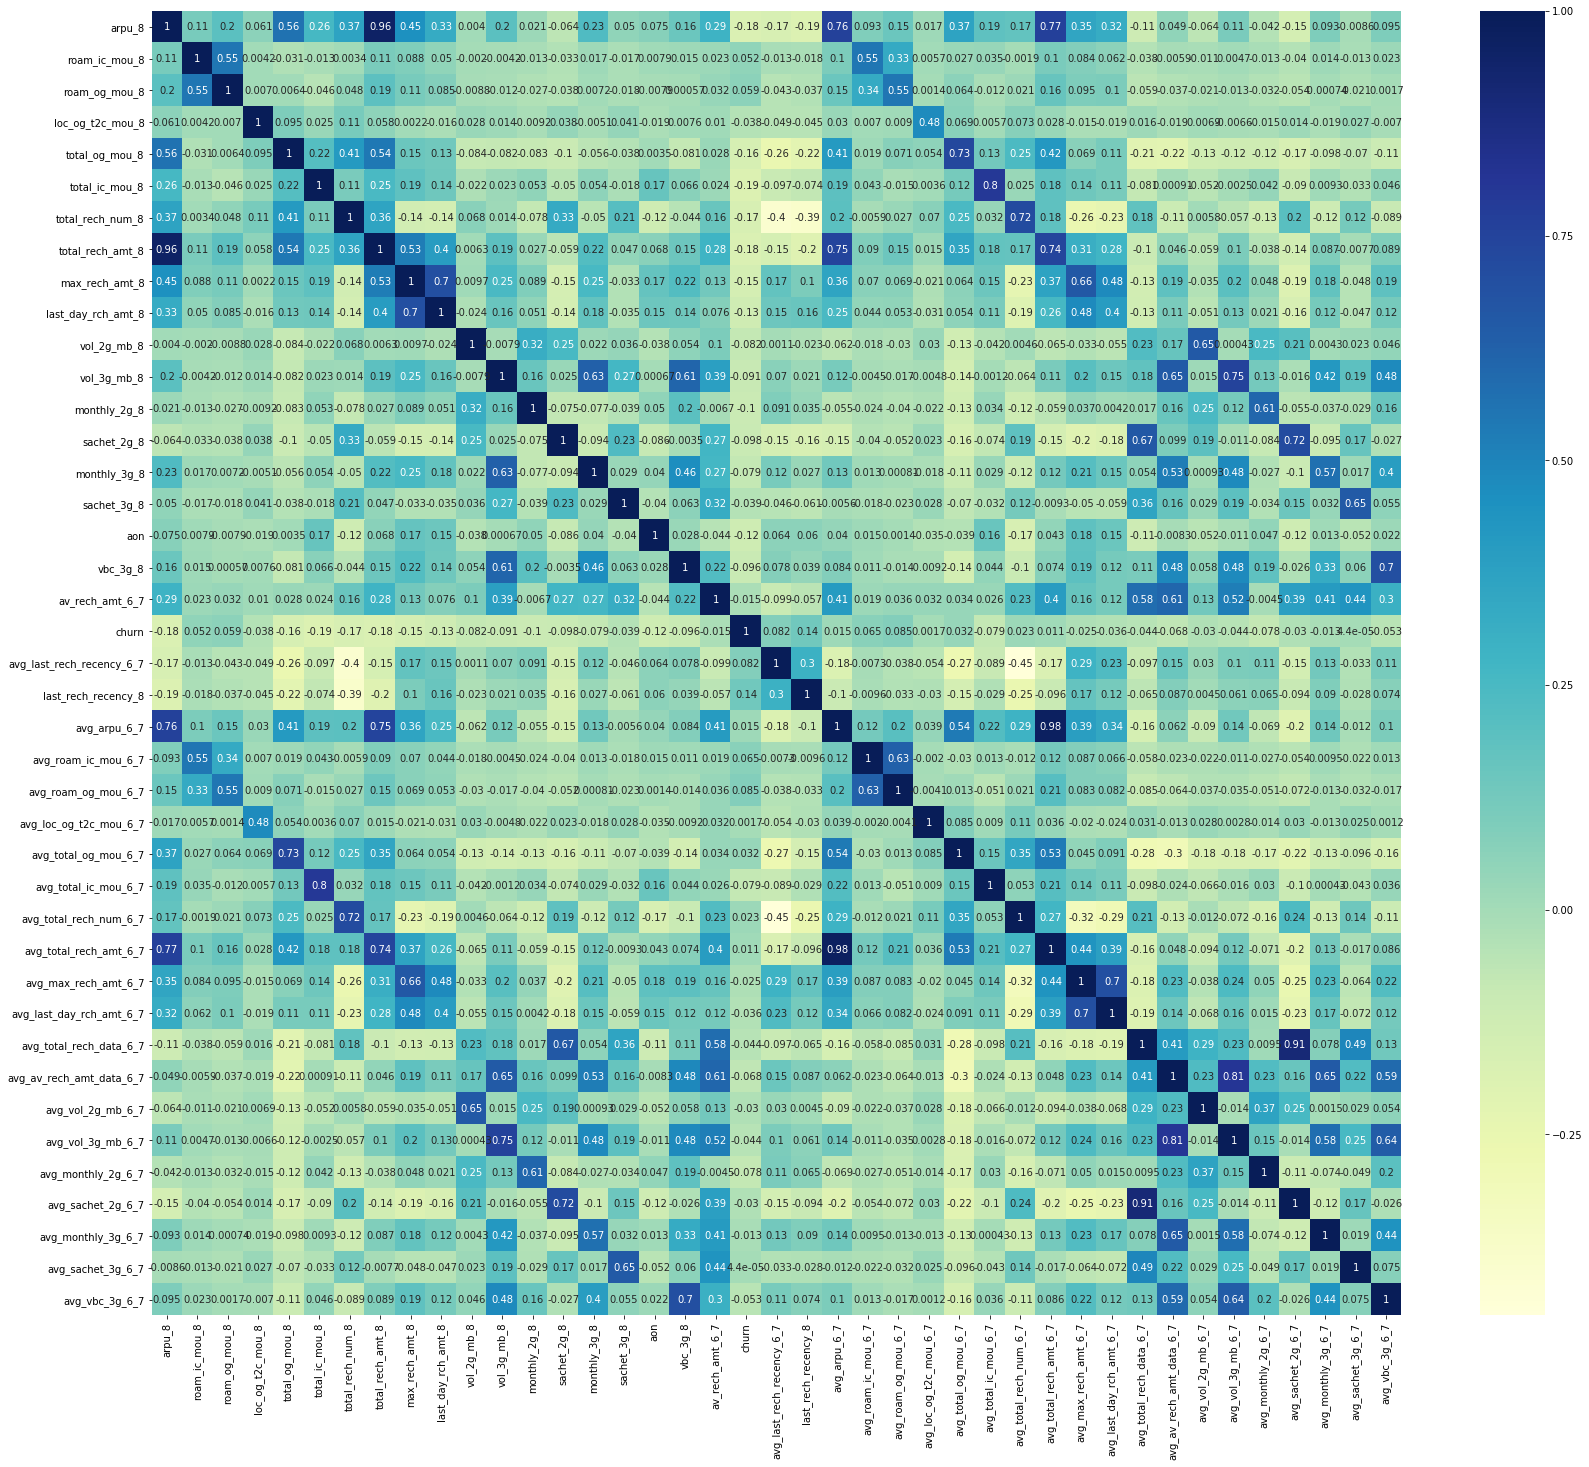

In [57]:
plt.figure(figsize=(28,24))
ax=sns.heatmap(df_high_valued.corr(), annot = True, cmap="YlGnBu")
top, bottom = ax.get_ylim()
ax.set_ylim(top+0.5, bottom-0.5)

In [58]:
df_high_valued.corr()

arpu_8  roam_ic_mou_8  roam_og_mou_8  \
arpu_8                     1.000000       0.112416       0.200178   
roam_ic_mou_8              0.112416       1.000000       0.548778   
roam_og_mou_8              0.200178       0.548778       1.000000   
loc_og_t2c_mou_8           0.061364       0.004160       0.006994   
total_og_mou_8             0.564300      -0.031293       0.006442   
total_ic_mou_8             0.262433      -0.012864      -0.046049   
total_rech_num_8           0.365044       0.003390       0.048025   
total_rech_amt_8           0.956287       0.108987       0.194745   
max_rech_amt_8             0.454245       0.088400       0.110220   
last_day_rch_amt_8         0.325920       0.050316       0.084616   
vol_2g_mb_8                0.004016      -0.001976      -0.008808   
vol_3g_mb_8                0.197114      -0.004216      -0.012399   
monthly_2g_8               0.021089      -0.012654      -0.027302   
sachet_2g_8               -0.064388      -0.032827      -0.037640   
monthly_3g_8               0.231603       0.016724       0.007196   
sachet_3g_8                0.049879      -0.017110      -0.018327   
aon                        0.074962       0.007946      -0.007901   
vbc_3g_8                   0.155257       0.015044       0.000566   
av_rech_amt_6_7            0.289359       0.022728       0.032417   
churn                     -0.177099       0.052484       0.059156   
avg_last_rech_recency_6_7 -0.166694      -0.013384      -0.043425   
last_rech_recency_8       -0.185395      -0.018041      -0.037096   
avg_arpu_6_7               0.759227       0.101808       0.153421   
avg_roam_ic_mou_6_7        0.092871       0.549802       0.335445   
avg_roam_og_mou_6_7        0.151374       0.331054       0.551336   
avg_loc_og_t2c_mou_6_7     0.016987       0.005680       0.001409   
avg_total_og_mou_6_7       0.368691       0.026869       0.063527   
avg_total_ic_mou_6_7       0.185088       0.035448      -0.012385   
avg_total_rech_num_6_7     0.174380      -0.001922       0.020727   
avg_total_rech_amt_6_7     0.767276       0.104339       0.164870   
avg_max_rech_amt_6_7       0.354510       0.083939       0.095262   
avg_last_day_rch_amt_6_7   0.322686       0.062056       0.102185   
avg_total_rech_data_6_7   -0.112333      -0.037841      -0.059307   
avg_av_rech_amt_data_6_7   0.049495      -0.005893      -0.036559   
avg_vol_2g_mb_6_7         -0.064376      -0.011282      -0.020766   
avg_vol_3g_mb_6_7          0.105969       0.004743      -0.013328   
avg_monthly_2g_6_7        -0.042268      -0.013214      -0.031839   
avg_sachet_2g_6_7         -0.146029      -0.040029      -0.053794   
avg_monthly_3g_6_7         0.092943       0.014115      -0.000744   
avg_sachet_3g_6_7         -0.008598      -0.012632      -0.020800   
avg_vbc_3g_6_7             0.095385       0.022880       0.001668   

                           loc_og_t2c_mou_8  total_og_mou_8  total_ic_mou_8  \
arpu_8                             0.061364        0.564300        0.262433   
roam_ic_mou_8                      0.004160       -0.031293       -0.012864   
roam_og_mou_8                      0.006994        0.006442       -0.046049   
loc_og_t2c_mou_8                   1.000000        0.094768        0.025056   
total_og_mou_8                     0.094768        1.000000        0.215151   
total_ic_mou_8                     0.025056        0.215151        1.000000   
total_rech_num_8                   0.112658        0.411391        0.105086   
total_rech_amt_8                   0.058295        0.544656        0.250502   
max_rech_amt_8                     0.002209        0.154009        0.185409   
last_day_rch_amt_8                -0.016033        0.132724        0.139786   
vol_2g_mb_8                        0.028351       -0.084484       -0.022451   
vol_3g_mb_8                        0.014009       -0.081805        0.022854   
monthly_2g_8                      -0.009161       -0.083408        0.052682   
sachet_2g_8             

In [59]:
# 96% correlation seen between 'total_rech_amt_8' and 'arpu_8', hence removing 'total_rech_amt_8'
# Similarly 'avg_total_rech_data_6_7' and 'avg_sachet_2g_6_7' are 91% correlated, hence removing 'avg_total_rech_data_6_7'
df_high_valued.drop(['total_rech_amt_8','avg_total_rech_data_6_7'], axis=1, inplace=True)

(39.0, 0.0)

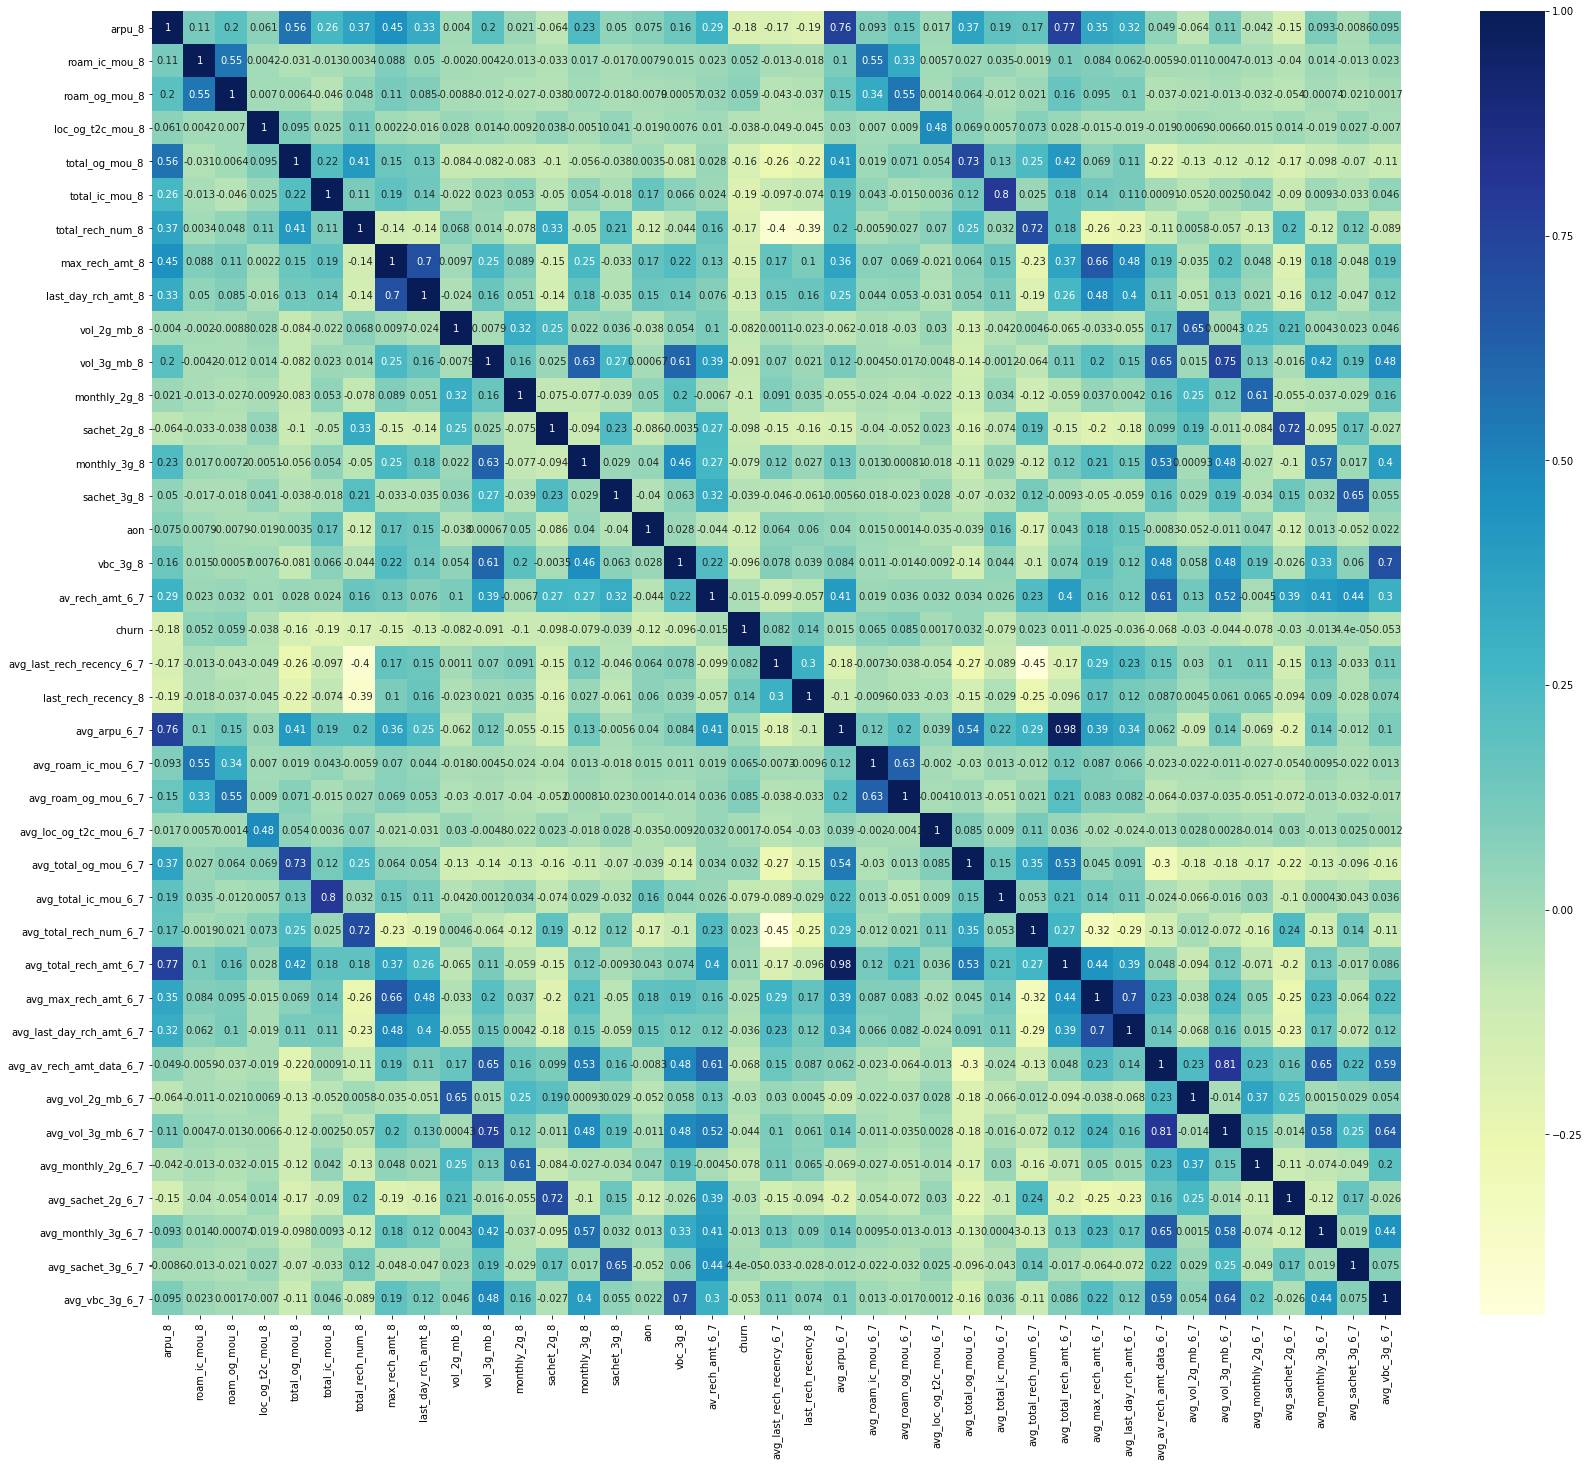

In [60]:
plt.figure(figsize=(28,24))
ax=sns.heatmap(df_high_valued.corr(), annot = True, cmap="YlGnBu")
top, bottom = ax.get_ylim()
ax.set_ylim(top+0.5, bottom-0.5)

In [61]:
df_high_valued.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30014 entries, 0 to 99998
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   arpu_8                     30014 non-null  float64
 1   roam_ic_mou_8              30014 non-null  float64
 2   roam_og_mou_8              30014 non-null  float64
 3   loc_og_t2c_mou_8           30014 non-null  float64
 4   total_og_mou_8             30014 non-null  float64
 5   total_ic_mou_8             30014 non-null  float64
 6   total_rech_num_8           30014 non-null  int64  
 7   max_rech_amt_8             30014 non-null  int64  
 8   last_day_rch_amt_8         30014 non-null  int64  
 9   vol_2g_mb_8                30014 non-null  float64
 10  vol_3g_mb_8                30014 non-null  float64
 11  monthly_2g_8               30014 non-null  int64  
 12  sachet_2g_8                30014 non-null  int64  
 13  monthly_3g_8               30014 non-null  int

## Outlier Treatment

In [62]:
df_high_valued.describe(percentiles=[0.0001,0.001,0.01,0.02,0.1,0.25,0.5,0.75,0.85,0.90,0.95,0.96,0.97,0.98,0.99, 0.995, 0.996,0.997,0.999,0.9999, 0.99999])

arpu_8  roam_ic_mou_8  roam_og_mou_8  loc_og_t2c_mou_8  \
count    30014.000000   30014.000000   30014.000000      30014.000000   
mean       498.277119      12.392753      19.694828          1.648852   
std        502.518042      73.637415     104.076444          6.977815   
min       -945.808000       0.000000       0.000000          0.000000   
0.01%     -146.733399       0.000000       0.000000          0.000000   
0.1%        -5.000000       0.000000       0.000000          0.000000   
1%           0.000000       0.000000       0.000000          0.000000   
2%           0.000000       0.000000       0.000000          0.000000   
10%         66.641300       0.000000       0.000000          0.000000   
25%        218.804000       0.000000       0.000000          0.000000   
50%        417.274500       0.000000       0.000000          0.000000   
75%        652.011500       0.000000       0.000000          0.000000   
85%        823.888300       3.080000       5.250000          2.050000   
90%        966.797600      15.010000      28.630000          4.440000   
95%       1246.882550      55.827500      99.322000          9.130000   
96%       1345.985800      74.508000     132.332800         11.140000   
97%       1465.434050     103.614400     175.852000         13.840000   
98%       1651.559620     159.611200     252.343600         18.239600   
99%       1976.251850     283.094800     424.804100         27.127400   
99.5%     2381.765175     413.451600     626.654750         36.849350   
99.6%     2560.363292     463.869800     712.681000         41.885840   
99.7%     2888.598186     539.588130     857.194590         47.033760   
99.9%     3975.582322     887.315000    1360.124150         70.359610   
99.99%   13504.731476    2394.324713    2860.011320        214.415254   
99.999%  29267.455796    3788.203709    4783.696322        337.282699   
max      33543.624000    4169.810000    5337.040000        351.830000   

         total_og_mou_8  total_ic_mou_8  total_rech_num_8  max_rech_amt_8  \
count      30014.000000    30014.000000      30014.000000    30014.000000   
mean         536.602718      276.139929          9.770440      158.513527   
std          691.438416      360.383244          9.176506      173.128733   
min            0.000000        0.000000          0.000000        0.000000   
0.01%          0.000000        0.000000          0.000000        0.000000   
0.1%           0.000000        0.000000          0.000000        0.000000   
1%             0.000000        0.000000          0.000000        0.000000   
2%             0.000000        0.000000          0.000000        0.000000   
10%            0.000000        2.969000          2.000000       23.000000   
25%           64.960000       57.990000          4.000000       50.000000   
50%          321.075000      169.100000          7.000000      130.000000   
75%          752.712500      356.420000         13.000000      198.000000   
85%         1070.817500      511.133000         17.000000      252.000000   
90%         1330.654000      646.845000         20.000000      252.000000   
95%         1809.575000      908.012500         27.000000      440.000000   
96%         1970.544400     1003.543200         30.000000      500.000000   
97%         2185.562000     1137.423000         32.000000      550.000000   
98%         2484.613800     1329.628800         37.000000      619.000000   
99%         3169.629300     1723.054100         44.000000      951.000000   
99.5%       3811.082100     2138.879100         52.000000     1000.000000   
99.6%       4071.051200     2258.089480         56.000000     1050.000000   
99.7%       4286.887660     2475.381150         60.961000     1098.000000   
99.9%       5698.345190     3531.811130         74.000000     1699.000000   
99.99%     10880.059111     5116.069109        121.998700     3299.000000   
99.999%    13984.594676     6043.844130        178.592460     4449.000000   
max        14043.060000     6066.630000  

In [63]:
Q1 = df_high_valued.quantile(0.25)
Q3 = df_high_valued.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

arpu_8                        433.207500
roam_ic_mou_8                   0.000000
roam_og_mou_8                   0.000000
loc_og_t2c_mou_8                0.000000
total_og_mou_8                687.752500
total_ic_mou_8                298.430000
total_rech_num_8                9.000000
max_rech_amt_8                148.000000
last_day_rch_amt_8            130.000000
vol_2g_mb_8                    47.980000
vol_3g_mb_8                   342.462500
monthly_2g_8                    0.000000
sachet_2g_8                     1.000000
monthly_3g_8                    0.000000
sachet_3g_8                     0.000000
aon                          1299.750000
vbc_3g_8                      119.810000
av_rech_amt_6_7               894.500000
churn                           0.000000
avg_last_rech_recency_6_7       4.000000
last_rech_recency_8             5.000000
avg_arpu_6_7                  330.027375
avg_roam_ic_mou_6_7             1.595000
avg_roam_og_mou_6_7             3.328750
avg_loc_og_t2c_m

In [64]:
print(((df_high_valued < (Q1 - 1.5 * IQR)) |(df_high_valued > (Q3 + 1.5 * IQR))).sum())

arpu_8                       1323
roam_ic_mou_8                5401
roam_og_mou_8                5370
loc_og_t2c_mou_8             7431
total_og_mou_8               1553
total_ic_mou_8               1978
total_rech_num_8             1594
max_rech_amt_8               1512
last_day_rch_amt_8           1071
vol_2g_mb_8                  5236
vol_3g_mb_8                  4172
monthly_2g_8                 4059
sachet_2g_8                  4022
monthly_3g_8                 4343
sachet_3g_8                  2602
aon                            51
vbc_3g_8                     5214
av_rech_amt_6_7              2647
churn                        2642
avg_last_rech_recency_6_7    1619
last_rech_recency_8          1947
avg_arpu_6_7                 1580
avg_roam_ic_mou_6_7          6405
avg_roam_og_mou_6_7          6487
avg_loc_og_t2c_mou_6_7       4738
avg_total_og_mou_6_7         1169
avg_total_ic_mou_6_7         1941
avg_total_rech_num_6_7       1685
avg_total_rech_amt_6_7       1587
avg_max_rech_a

##### Capping the outliers with 99.9th percentile

In [65]:
for col in df_high_valued.columns.to_list():
    df_high_valued[col] = np.where(df_high_valued[col] > df_high_valued[col].quantile(0.999), df_high_valued[col].quantile(0.999),df_high_valued[col])

df_high_valued['arpu_8'] = np.where(df_high_valued['arpu_8'] < df_high_valued['arpu_8'].quantile(0.001), df_high_valued['arpu_8'].quantile(0.001) ,df_high_valued['arpu_8'])
df_high_valued['avg_arpu_6_7'] = np.where(df_high_valued['avg_arpu_6_7'] < df_high_valued['avg_arpu_6_7'].quantile(0.001), df_high_valued['avg_arpu_6_7'].quantile(0.001) ,df_high_valued['avg_arpu_6_7'])

In [66]:
df_high_valued.describe(percentiles=[0.0001,0.001,0.01,0.02,0.1,0.25,0.5,0.75,0.85,0.90,0.95,0.96,0.97,0.98,0.99, 0.995, 0.996,0.997,0.999,0.9999, 0.99999])

arpu_8  roam_ic_mou_8  roam_og_mou_8  loc_og_t2c_mou_8  \
count    30014.000000   30014.000000   30014.000000      30014.000000   
mean       494.535374      11.781832      19.124136          1.583478   
std        418.875831      58.794255      91.165721          5.521682   
min         -5.000000       0.000000       0.000000          0.000000   
0.01%       -5.000000       0.000000       0.000000          0.000000   
0.1%        -5.000000       0.000000       0.000000          0.000000   
1%           0.000000       0.000000       0.000000          0.000000   
2%           0.000000       0.000000       0.000000          0.000000   
10%         66.641300       0.000000       0.000000          0.000000   
25%        218.804000       0.000000       0.000000          0.000000   
50%        417.274500       0.000000       0.000000          0.000000   
75%        652.011500       0.000000       0.000000          0.000000   
85%        823.888300       3.080000       5.250000          2.050000   
90%        966.797600      15.010000      28.630000          4.440000   
95%       1246.882550      55.827500      99.322000          9.130000   
96%       1345.985800      74.508000     132.332800         11.140000   
97%       1465.434050     103.614400     175.852000         13.840000   
98%       1651.559620     159.611200     252.343600         18.239600   
99%       1976.251850     283.094800     424.804100         27.127400   
99.5%     2381.765175     413.451600     626.654750         36.849350   
99.6%     2560.363292     463.869800     712.681000         41.885840   
99.7%     2888.598186     539.588130     857.194590         47.033760   
99.9%     3974.912467     887.250845    1359.990066         70.359225   
99.99%    3975.582322     887.315000    1360.124150         70.359610   
99.999%   3975.582322     887.315000    1360.124150         70.359610   
max       3975.582322     887.315000    1360.124150         70.359610   

         total_og_mou_8  total_ic_mou_8  total_rech_num_8  max_rech_amt_8  \
count      30014.000000    30014.000000      30014.000000    30014.000000   
mean         534.685116      275.436686          9.749517      157.426134   
std          670.865656      352.626270          8.968232      158.107639   
min            0.000000        0.000000          0.000000        0.000000   
0.01%          0.000000        0.000000          0.000000        0.000000   
0.1%           0.000000        0.000000          0.000000        0.000000   
1%             0.000000        0.000000          0.000000        0.000000   
2%             0.000000        0.000000          0.000000        0.000000   
10%            0.000000        2.969000          2.000000       23.000000   
25%           64.960000       57.990000          4.000000       50.000000   
50%          321.075000      169.100000          7.000000      130.000000   
75%          752.712500      356.420000         13.000000      198.000000   
85%         1070.817500      511.133000         17.000000      252.000000   
90%         1330.654000      646.845000         20.000000      252.000000   
95%         1809.575000      908.012500         27.000000      440.000000   
96%         1970.544400     1003.543200         30.000000      500.000000   
97%         2185.562000     1137.423000         32.000000      550.000000   
98%         2484.613800     1329.628800         37.000000      619.000000   
99%         3169.629300     1723.054100         44.000000      951.000000   
99.5%       3811.082100     2138.879100         52.000000     1000.000000   
99.6%       4071.051200     2258.089480         56.000000     1050.000000   
99.7%       4286.887660     2475.381150         60.961000     1098.000000   
99.9%       5698.212133     3531.644455         74.000000     1699.000000   
99.99%      5698.345190     3531.811130         74.000000     1699.000000   
99.999%     5698.345190     3531.811130         74.000000     1699.000000   
max         5698.345190     3531.811130  

# EDA

In [67]:
composition=(100*(df_high_valued['churn'].sum()/len(df_high_valued.index)))
composition

8.802558805890584

In [68]:
composition=(100*(df_high_valued.groupby('churn')['arpu_8'].count()/len(df_high_valued.index))).to_frame().reset_index()
composition.rename(columns={"arpu_8": "Percentage"}, inplace=True)
composition

churn  Percentage
0    0.0   91.197441
1    1.0    8.802559

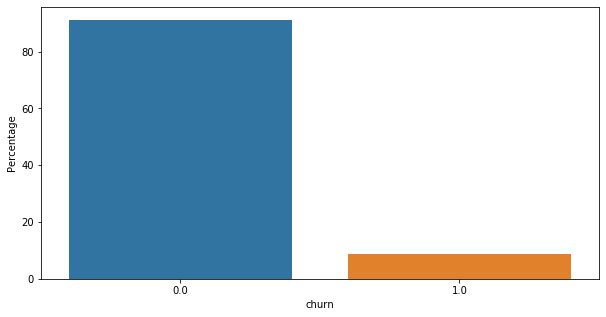

In [69]:
plt.figure(figsize=(10,5))
sns.barplot(data=composition, x='churn', y='Percentage')
plt.show()

38


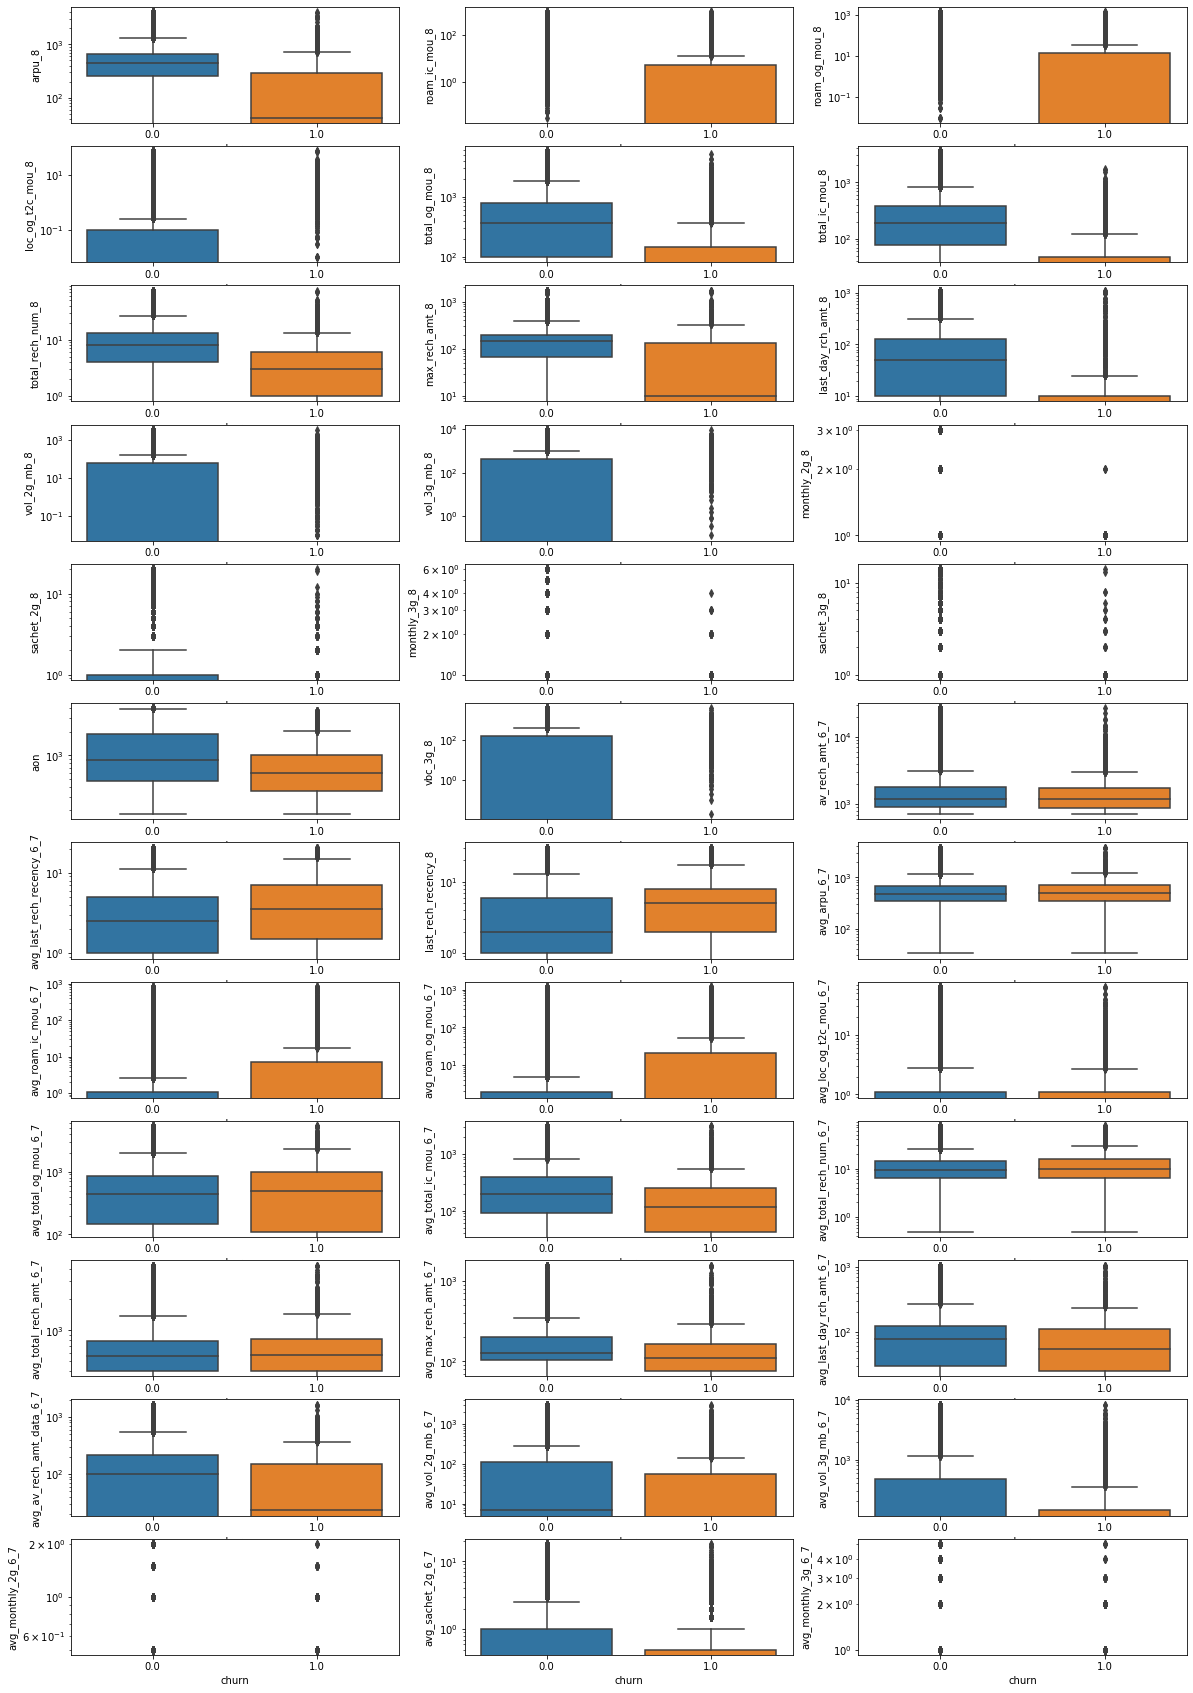

In [70]:
columns=list(df_high_valued.columns)
columns.remove('churn')
print(len(columns))
plt.figure(figsize=(20,38))
for count in range(0,len(columns)-2):
    plt.subplot(15, 3, count+1)
    sns.boxplot(y=columns[count], x='churn', data=df_high_valued)
    plt.yscale('log')
plt.show()

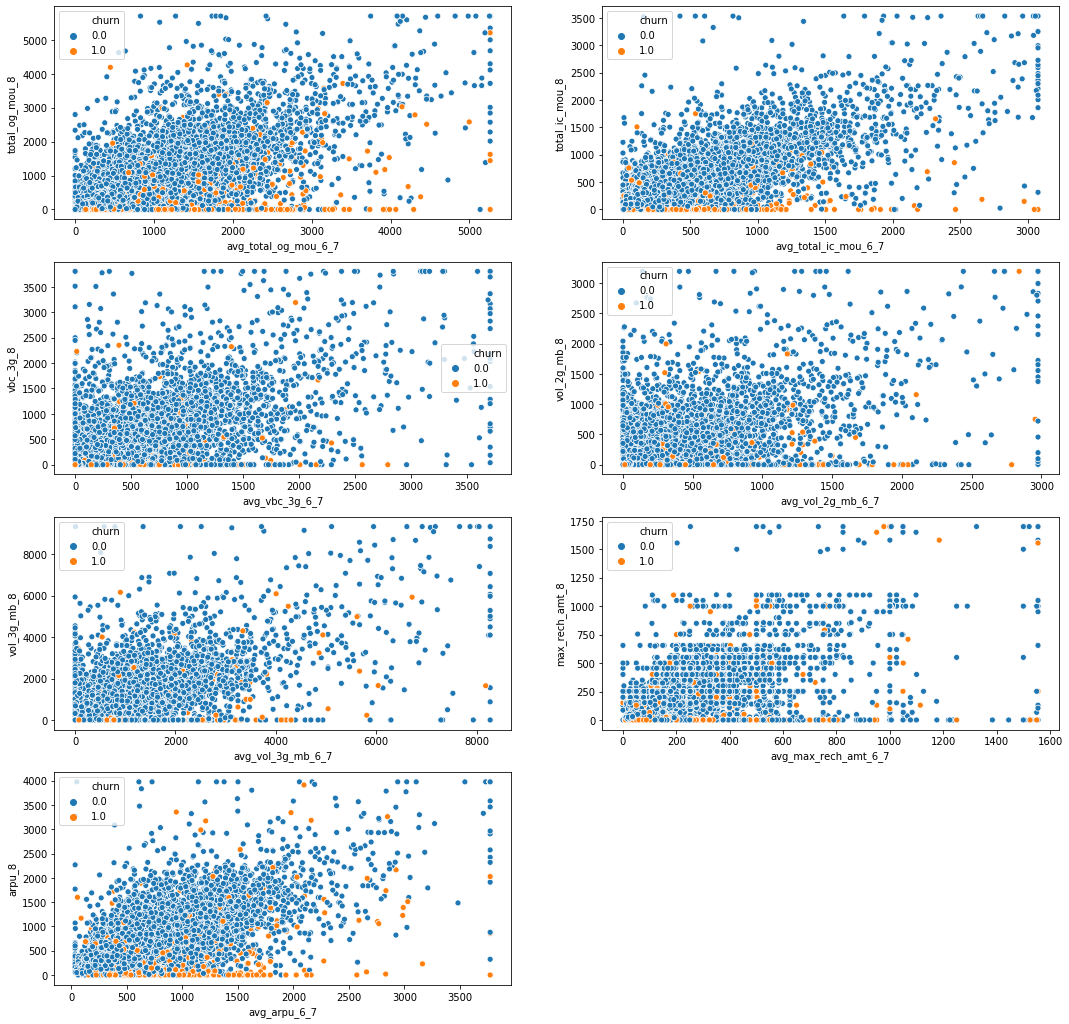

In [71]:
plt.figure(figsize=(18,18))
plt.subplot(421)
sns.scatterplot(data=df_high_valued,x='avg_total_og_mou_6_7', y='total_og_mou_8', hue='churn')
plt.subplot(422)
sns.scatterplot(data=df_high_valued,x='avg_total_ic_mou_6_7', y='total_ic_mou_8', hue='churn')
plt.subplot(423)
sns.scatterplot(data=df_high_valued,x='avg_vbc_3g_6_7', y='vbc_3g_8', hue='churn')
plt.subplot(424)
sns.scatterplot(data=df_high_valued,x='avg_vol_2g_mb_6_7', y='vol_2g_mb_8', hue='churn')
plt.subplot(425)
sns.scatterplot(data=df_high_valued,x='avg_vol_3g_mb_6_7', y='vol_3g_mb_8', hue='churn')
plt.subplot(426)
sns.scatterplot(data=df_high_valued,x='avg_max_rech_amt_6_7', y='max_rech_amt_8', hue='churn')
plt.subplot(427)
sns.scatterplot(data=df_high_valued,x='avg_arpu_6_7', y='arpu_8', hue='churn')


### From the above visualizations, it is clear that the plotted features shows varying trend in the good phase compared to action phase
### Hence these might be good predictors in predicting the Churn

In [72]:
df_high_valued.nunique()

arpu_8                       27795
roam_ic_mou_8                 3400
roam_og_mou_8                 3977
loc_og_t2c_mou_8              1666
total_og_mou_8               22024
total_ic_mou_8               19392
total_rech_num_8                74
max_rech_amt_8                 172
last_day_rch_amt_8             166
vol_2g_mb_8                   9973
vol_3g_mb_8                   9944
monthly_2g_8                     4
sachet_2g_8                     21
monthly_3g_8                     7
sachet_3g_8                     15
aon                           3282
vbc_3g_8                      9663
av_rech_amt_6_7               6431
churn                            2
avg_last_rech_recency_6_7       42
last_rech_recency_8             31
avg_arpu_6_7                 29707
avg_roam_ic_mou_6_7           5707
avg_roam_og_mou_6_7           6642
avg_loc_og_t2c_mou_6_7        3080
avg_total_og_mou_6_7         27528
avg_total_ic_mou_6_7         26262
avg_total_rech_num_6_7         143
avg_total_rech_amt_6

#### Test Train Split

In [73]:
# Putting feature variable to X
X = df_high_valued.drop(['churn'],axis=1)

# Putting response variable to y
y = df_high_valued['churn']

##### Performing a stratified split on target variable since the data set is class imbalanced

In [74]:
#Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32, stratify=y)


In [75]:
X_train.shape

(21009, 38)

##### Scaling the data set
- Fit and transform the train data set
- Only Transform the test set

In [76]:
#Scaling the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Addressing class imbalance
- Using SMOTE technique for class imbalance

In [77]:
smote = SMOTE(random_state=32, sampling_strategy=1.0)
X_train, y_train = smote.fit_sample(X_train, y_train)

#### Perform PCA

In [78]:
pca = PCA(random_state=32)
pca.fit(X_train)

PCA(random_state=32)

In [79]:
np.cumsum(pca.explained_variance_ratio_)

array([0.15668405, 0.28160363, 0.38584345, 0.46557302, 0.51976339,
       0.55995553, 0.59831967, 0.63418719, 0.66849311, 0.69881619,
       0.72853621, 0.75684492, 0.77795948, 0.79748595, 0.81562261,
       0.83287616, 0.84960423, 0.86539869, 0.88082222, 0.89345994,
       0.90568439, 0.91760853, 0.92763334, 0.93718269, 0.94509402,
       0.95247601, 0.95974563, 0.96605883, 0.97196806, 0.97733508,
       0.98205598, 0.98650601, 0.99011684, 0.99299494, 0.99558099,
       0.99756414, 0.99941598, 1.        ])

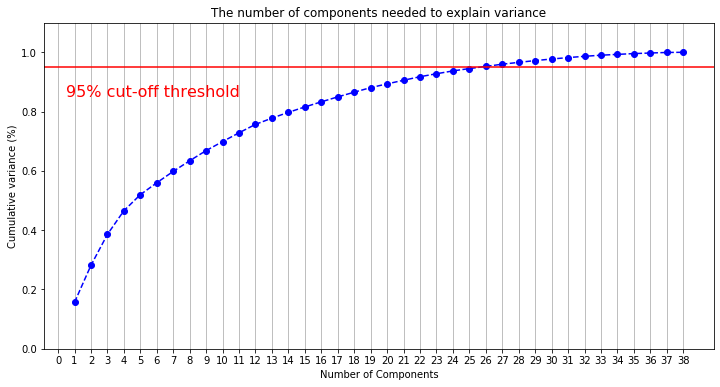

In [80]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 39, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 39, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

Almost 95% variance is explained by just 26 variables. Hence executing PCA with 26 components

In [81]:
pca_final = IncrementalPCA(n_components=26)
X_train = pca_final.fit_transform(X_train)
X_train.shape

(38320, 26)

In [82]:
corrmat = np.corrcoef(X_train.transpose())
corrmat.shape

(26, 26)

(26.0, 0.0)

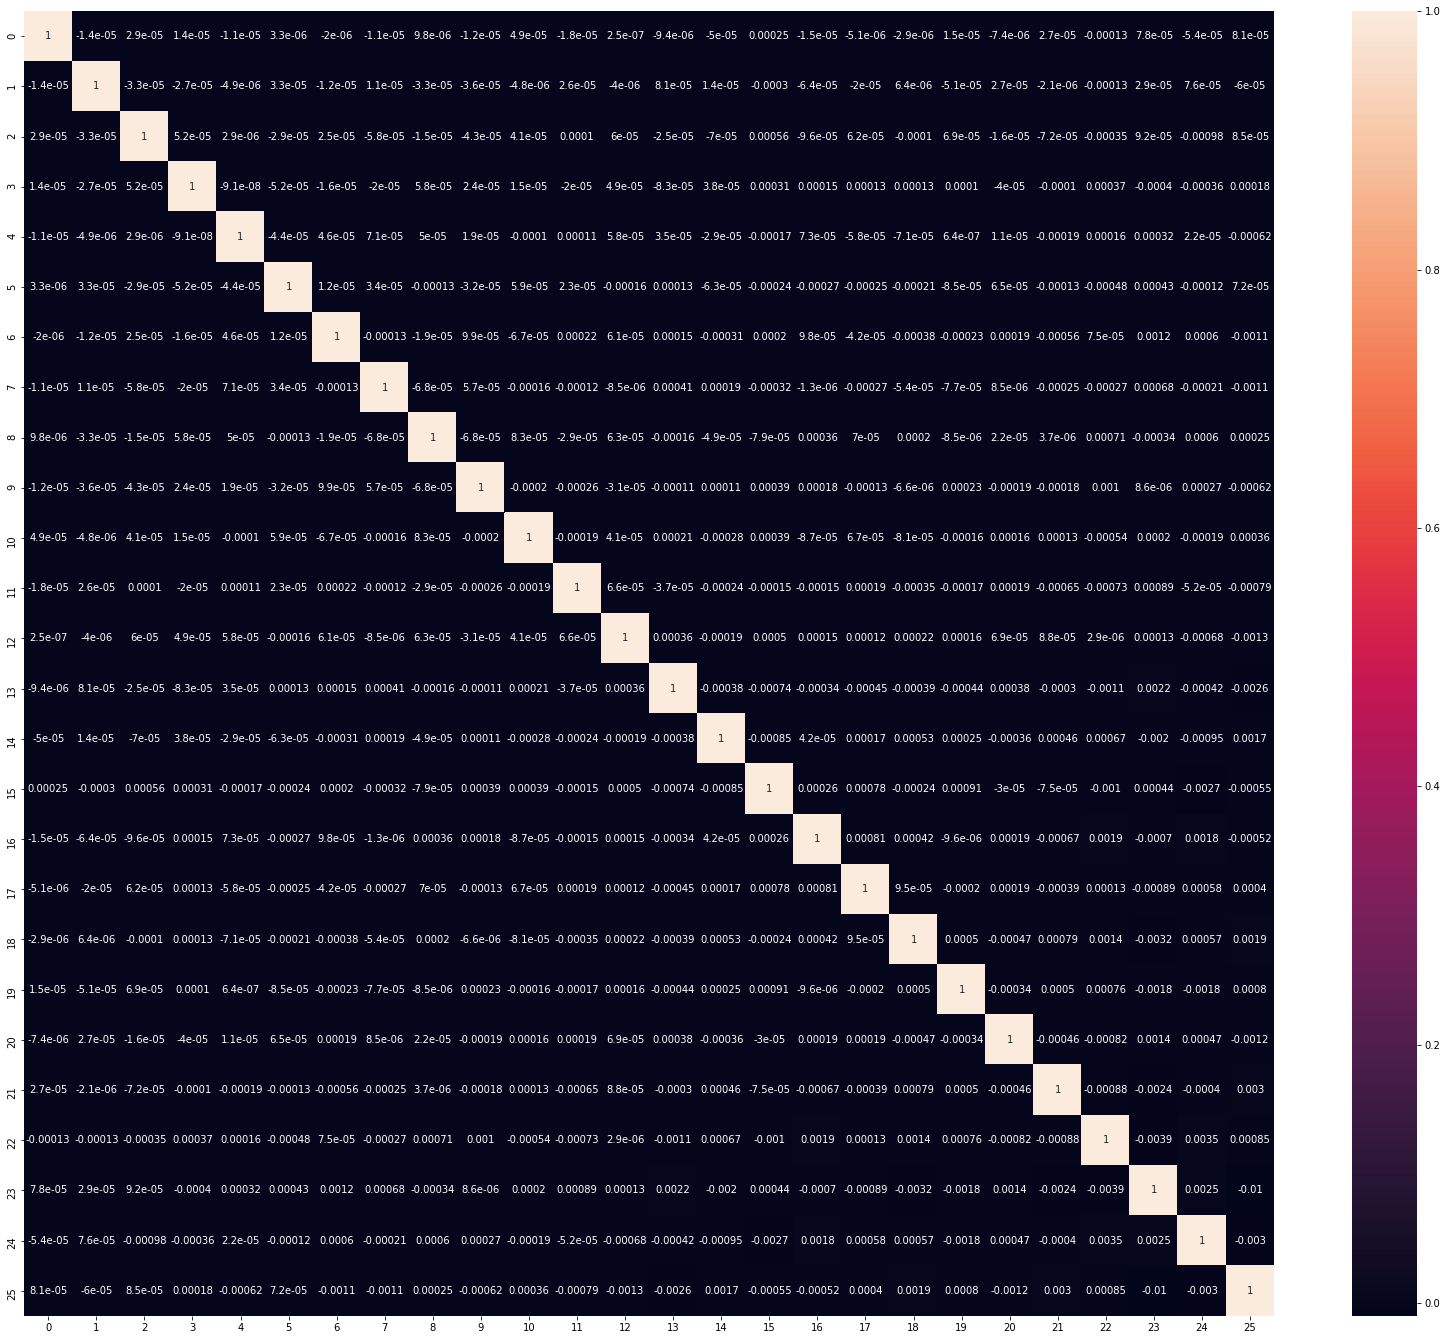

In [83]:
plt.figure(figsize=[28,24])
ax=sns.heatmap(corrmat, annot=True)
top, bottom = ax.get_ylim()
ax.set_ylim(top+0.5, bottom-0.5)

In [84]:
X_test.shape

(9005, 38)

In [85]:
#Applying the transformation on the test set
X_test = pca_final.transform(X_test)
X_test.shape

(9005, 26)

### Before modelling, figuring out the right metric for the modelling exercise
- According to business statement, churners have to be identified correctly
- Means, it is ok to predict "non churners" as "churners" (Basically False Positives) but most of the churners should be correctly predicted as Churners (False Negatives should be low)
- To address this, `Recall` is the best metric which evaluates how good the churners are predicted by the model given all the actual churners
- Hence using the scoring parameter as 'Recall' in all the Gridsearch done for various models

## Modelling
## Model - 1 `Logistic Regression`

- Using a Stratified K fold to make sure that folds are created by considering class balance

In [86]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 32)

# Set the parameters by cross-validation
hyper_params = [ {'C': [0.01, 0.1, 1, 10, 100, 1000]}]

# specify model
model = LogisticRegression()

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 100,
                        return_train_score=True,
                        n_jobs=-1)      

# fit the model
model_cv.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Memmapping (shape=(38320, 26), dtype=float64) to new file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pick

Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   14.7s
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   14.9s
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (

##### Using the best value for 'C' to train and evaluate the model

In [87]:
logistic_pca = LogisticRegression(C=best_hyperparams['C'])
logistic_pca = logistic_pca.fit(X_train, y_train)
y_train_pred = logistic_pca.predict(X_train)
y_test_pred = logistic_pca.predict(X_test)
pred_probs_test = logistic_pca.predict_proba(X_test)
"ROC:{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test[:,1]))

'ROC:0.89'

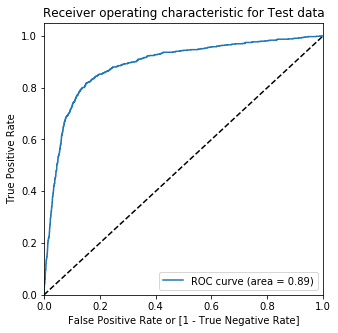

In [88]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for Test data')
    plt.legend(loc="lower right")
    plt.show()

    return None

draw_roc(y_test, pred_probs_test[:,1])

In [89]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[6728 1484]
 [ 128  665]]


In [90]:
print("Training data Metrics")
print("Accuracy:",metrics.accuracy_score(y_train, y_train_pred))
print("Precision:",precision_score(y_train, y_train_pred))
print("Recall:",recall_score(y_train, y_train_pred))

Training data Metrics
Accuracy: 0.8394050104384133
Precision: 0.8293992503292473
Recall: 0.8545929018789145


In [91]:
print("Test data Metrics")
print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred))
print("Precision:",precision_score(y_test, y_test_pred))
print("Recall:",recall_score(y_test, y_test_pred))

Test data Metrics
Accuracy: 0.820988339811216
Precision: 0.30944625407166126
Recall: 0.8385876418663304


## Recall score with Logistic Regression is 83%
<br>

## Model 2 - `SVM`

In [92]:
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 32)

# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]

# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 100,
                        return_train_score=True,
                        n_jobs=-1)      

# fit the model
model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Memmapping (shape=(38320, 26), dtype=float64) to new file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25546,), dtype=int32).
Pickling array (shape=(12774,), dtype=int32).
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
P

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  9.5min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed: 10.0min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed: 10.5min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-229

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=32, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='recall', verbose=100)

In [93]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0      59.935958      0.461544        13.329225        0.055621       1   
1      66.659950      2.870600        16.535938        0.946863       1   
2      81.496321      2.894184        22.064275        0.044072       1   
3      50.229344      1.221968        12.232121        2.393432      10   
4      63.472412      1.166846        16.421559        1.189381      10   

  param_gamma                     params  split0_test_score  \
0        0.01    {'C': 1, 'gamma': 0.01}           0.881165   
1       0.001   {'C': 1, 'gamma': 0.001}           0.841240   
2      0.0001  {'C': 1, 'gamma': 0.0001}           0.839831   
3        0.01   {'C': 10, 'gamma': 0.01}           0.914357   
4       0.001  {'C': 10, 'gamma': 0.001}           0.853609   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.891951           0.897761         0.890292        0.006876   
1           0.846070           0.851260         0.846190        0.004092   
2           0.844817           0.847816         0.844155        0.003293   
3           0.917946           0.920777         0.917693        0.002627   
4           0.863608           0.865665         0.860960        0.005266   

   rank_test_score  split0_train_score  split1_train_score  \
0                5            0.895639            0.892673   
1               10            0.848195            0.846250   
2               12            0.845220            0.842336   
3                3            0.927425            0.921246   
4                8            0.866437            0.860263   

   split2_train_score  mean_train_score  std_train_score  
0            0.892273          0.893528         0.001502  
1            0.845455          0.846634         0.001151  
2            0.845064          0.844207         0.001324  
3            0.923432          0.924035         0.002558  
4            0.858686          0.861795         0.003345

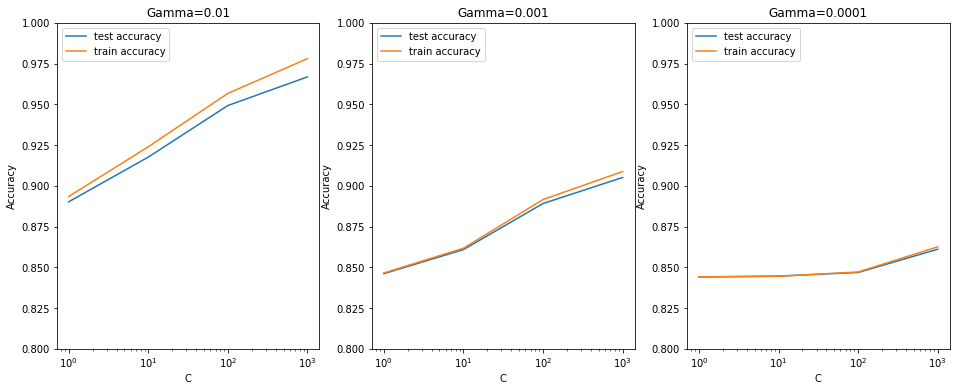

In [94]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [95]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9668582389851189 corresponding to hyperparameters {'C': 1000, 'gamma': 0.01}


In [96]:
X_train.shape

(38320, 26)

In [97]:
X_test.shape

(9005, 26)

In [98]:
# model
model = SVC(C=best_hyperparams['C'], gamma=best_hyperparams['gamma'], kernel="rbf", class_weight='balanced')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# metrics
print(metrics.confusion_matrix(y_test, y_pred), "\n")
print("accuracy", metrics.accuracy_score(y_test, y_pred))
print("precision", metrics.precision_score(y_test, y_pred))
print("sensitivity/recall", metrics.recall_score(y_test, y_pred))

print(classification_report(y_test,y_pred))

[[7438  774]
 [ 224  569]] 

accuracy 0.8891726818434204
precision 0.4236783320923306
sensitivity/recall 0.7175283732660782
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94      8212
         1.0       0.42      0.72      0.53       793

    accuracy                           0.89      9005
   macro avg       0.70      0.81      0.73      9005
weighted avg       0.92      0.89      0.90      9005



- With `C=1000` and `gamma = 0.01`, test set had a `Recall` of `72%`

## Model - 3 `Random Forest`

In [99]:
n_folds=3
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 100, scoring="recall")
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Memmapping (shape=(38320, 26), dtype=float64) to new file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pi

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.6min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:  2.6min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  2.6min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:  5.6min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  5.9min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:  6.2min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:  9.1min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  9.1min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:  9.4min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 15.0min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 15.0min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed: 15.3min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed: 21.3min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 103 tasks      | elapsed: 21.3min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 21.9min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done 123 tasks      | elapsed: 26.6min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 26.9min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed: 27.0min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 31.6min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 32.3min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 32.9min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 36.9min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 166 tasks      | elapsed: 37.0min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 167 tasks      | elapsed: 37.4min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed: 42.8min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 187 tasks      | elapsed: 43.3min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed: 43.4min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed: 51.6min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed: 51.9min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed: 52.1min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed: 56.3min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 229 tasks      | elapsed: 56.3min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed: 56.6min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed: 60.7min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed: 60.8min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 251 tasks      | elapsed: 61.2min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed: 63.9min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed: 64.1min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 64.2min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed: 66.8min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed: 66.8min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 293 tasks      | elapsed: 66.9min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed: 72.0min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 313 tasks      | elapsed: 72.1min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed: 72.5min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 77.5min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed: 77.6min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 335 tasks      | elapsed: 77.8min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-22936

Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(30656,), dtype=int32).
Pickling array (shape=(7664,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 357 out of 360 | elapsed: 83.9min remaining:   42.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 84.9min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 8, 10], 'max_features': [5, 10],
                         'min_samples_leaf': range(100, 400, 200),
                         'min_samples_split': range(200, 500, 200),
                         'n_estimators': [100, 200, 300]},
             scoring='recall', verbose=100)

In [100]:
# printing the optimal accuracy score and hyperparameters
print('Best Accuracy',grid_search.best_score_,'using',grid_search.best_params_)
best_hyperparams = grid_search.best_params_

Best Accuracy 0.8558455114822546 using {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 300}


In [101]:
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=best_hyperparams['max_depth'],
                             min_samples_leaf=best_hyperparams['min_samples_leaf'], 
                             min_samples_split=best_hyperparams['min_samples_split'],
                             max_features=best_hyperparams['max_features'],
                             n_estimators=best_hyperparams['n_estimators'],
                             class_weight='balanced')
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print("accuracy", metrics.accuracy_score(y_test, predictions))
print("precision", metrics.precision_score(y_test, predictions))
print("sensitivity/recall", metrics.recall_score(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.86      0.91      8212
         1.0       0.35      0.82      0.49       793

    accuracy                           0.85      9005
   macro avg       0.67      0.84      0.70      9005
weighted avg       0.92      0.85      0.88      9005

[[7036 1176]
 [ 146  647]]
accuracy 0.8531926707384786
precision 0.35490948985189247
sensitivity/recall 0.8158890290037831


- Though the max_depth is suggested as 10 by GridSearch, our focus is primarily on Recall score.
- Let us try to reduce the depth to 5 and check the recall score

In [102]:
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=best_hyperparams['min_samples_leaf'], 
                             min_samples_split=best_hyperparams['min_samples_split'],
                             max_features=best_hyperparams['max_features'],
                             n_estimators=best_hyperparams['n_estimators'],
                            class_weight='balanced')
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print("accuracy", metrics.accuracy_score(y_test, predictions))
print("precision", metrics.precision_score(y_test, predictions))
print("sensitivity/recall", metrics.recall_score(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      8212
         1.0       0.31      0.81      0.45       793

    accuracy                           0.82      9005
   macro avg       0.64      0.82      0.67      9005
weighted avg       0.92      0.82      0.86      9005

[[6779 1433]
 [ 147  646]]
accuracy 0.824541921154914
precision 0.31072631072631074
sensitivity/recall 0.8146279949558638


- Though reducing max_depth to 5, recall score is same. So better to go with less number of depth for a generalised model

# Model - 4 `XGBoost`

In [103]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9],
             'gamma': [0,0.25,1.0],
             'reg_lambda': [0, 1.0, 10.0]}


# specify model
xgb_model = XGBClassifier(max_depth=5, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 100,
                        return_train_score=True,
                        n_jobs=-1)

In [104]:
# fit the model
model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Memmapping (shape=(38320, 26), dtype=float64) to new file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25546,), dtype=int32).
Pickling array (shape=(12774,), dtype=int32).
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.0min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:  3.1min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  3.1min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-229

[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:  6.1min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  6.5min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:  6.5min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-229

[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:  9.3min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  9.6min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:  9.8min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-229

[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 12.8min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 12.9min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed: 12.9min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-229

[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed: 15.8min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 103 tasks      | elapsed: 16.3min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 16.3min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-229

[Parallel(n_jobs=-1)]: Done 123 tasks      | elapsed: 19.3min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 19.6min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed: 19.8min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-229

[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 22.8min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 22.9min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-2293629219720-0cf5fee674104eb281fcecae6697963c.pkl
Pickling array (shape=(38320,), dtype=float64).
Pickling array (shape=(25547,), dtype=int32).
Pickling array (shape=(12773,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 22.9min
Memmapping (shape=(38320, 26), dtype=float64) to old file C:\Users\e0368301\AppData\Local\Temp\joblib_memmapping_folder_17632_9385975486\17632-229

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=5, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [105]:
# printing the optimal accuracy score and hyperparameters
print('Best Accuracy',model_cv.best_score_,'using',model_cv.best_params_)
best_hyperparams = model_cv.best_params_

Best Accuracy 0.9732779204444486 using {'gamma': 0.25, 'learning_rate': 0.6, 'reg_lambda': 1.0, 'subsample': 0.9}


In [106]:
# chosen hyperparameters
params = {'learning_rate': best_hyperparams['learning_rate'],
          'max_depth': 5, 
          'n_estimators':200,
          'subsample':best_hyperparams['subsample'],
          'reg_lambda':best_hyperparams['reg_lambda'],
          'gamma':best_hyperparams['gamma'],
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train, y_train)

[19:58:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              params={'gamma': 0.25, 'learning_rate': 0.6, 'max_depth': 5,
                      'n_estimators': 200, 'objective': 'binary:logistic',
                      'reg_lambda': 1.0, 'subsample': 0.9},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [107]:
y_pred_prob = model.predict_proba(X_test)

In [108]:
print(metrics.roc_auc_score(y_test, y_pred_prob[:, 1]))

0.8963198751373594


In [109]:
y_test_pred=model.predict(X_test)
print(classification_report(y_test,y_test_pred))
print(confusion_matrix(y_test,y_test_pred))
print("accuracy", metrics.accuracy_score(y_test, y_test_pred))
print("precision", metrics.precision_score(y_test, y_test_pred))
print("sensitivity/recall", metrics.recall_score(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94      8212
         1.0       0.44      0.70      0.54       793

    accuracy                           0.90      9005
   macro avg       0.71      0.81      0.74      9005
weighted avg       0.92      0.90      0.91      9005

[[7506  706]
 [ 236  557]]
accuracy 0.8953914491948918
precision 0.4410134600158353
sensitivity/recall 0.7023959646910467


# Summary of Results on Test data for various Models

Model|Accuracy(%)|Precision(%)|Recall(%)
-|-|-|-
Logistic Regression|82.1|30.1|83.8
SVM|88.9|42.4|71.7
Random Forest|82.4|31|81.4
XGBoost|89.5|44.1|70.2

##### From Accuracy pov, XGBoost is the best model with an accuracy of 90%
### But for the given Business problem, Recall is the best metric
## Based on Recall, Logistic Regression is the best model with 83% Recall
### All the predictions are done with the cutoff probability of 0.5
### Recall value could be increased by using a probability cutoff threshold less than 0.5 as the intention is to decrease the `Fase Negatives`

# Identifying the predictor variables

## Logistic Regression used for this purpose

In [110]:
df_high_valued.head()

arpu_8  roam_ic_mou_8  roam_og_mou_8  loc_og_t2c_mou_8  total_og_mou_8  \
0    213.803           0.00           0.00              0.00            0.00   
7   3171.480          31.64          38.06              0.00          350.16   
8    137.362           0.00           0.00              7.15          171.56   
16   187.894           0.00           0.00              0.00          233.38   
17    25.499           4.81          13.34              0.00            0.00   

    total_ic_mou_8  total_rech_num_8  max_rech_amt_8  last_day_rch_amt_8  \
0             5.44               2.0           252.0               252.0   
7           428.74               7.0          1580.0               779.0   
8            16.54              14.0            30.0                10.0   
16          294.46               2.0           130.0               130.0   
17            0.00               4.0            30.0                 0.0   

    vol_2g_mb_8  vol_3g_mb_8  monthly_2g_8  sachet_2g_8  monthly_3g_8  \
0          5.75       109.61           0.0          0.0           1.0   
7          0.00         0.00           0.0          0.0           0.0   
8          0.03        11.94           0.0          3.0           0.0   
16         0.00         0.00           0.0          0.0           0.0   
17         0.00         0.00           0.0          0.0           0.0   

    sachet_3g_8    aon  vbc_3g_8  av_rech_amt_6_7  churn  \
0           0.0  968.0     30.40            866.0    1.0   
7           0.0  802.0     57.74           1975.0    1.0   
8           0.0  315.0     21.03            914.5    0.0   
16          0.0  511.0      0.00            744.0    0.0   
17          0.0  667.0      0.00            816.0    0.0   

    avg_last_rech_recency_6_7  last_rech_recency_8  avg_arpu_6_7  \
0                        12.0                 23.0      206.1005   
7                         4.5                  5.0     1209.5150   
8                         2.5                  1.0      435.4720   
16                        0.0                 17.0      365.4220   
17                        0.5                  6.0      354.4940   

    avg_roam_ic_mou_6_7  avg_roam_og_mou_6_7  avg_loc_og_t2c_mou_6_7  \
0                 0.000                0.000                     0.0   
7                24.860               18.165                     0.0   
8                 0.000                0.000                     0.0   
16                1.415                8.870                     0.0   
17                2.380                4.230                     0.0   

    avg_total_og_mou_6_7  avg_total_ic_mou_6_7  avg_total_rech_num_6_7  \
0                  0.000                 0.000                     3.5   
7                548.385               592.250                     5.0   
8                470.010                66.175                    20.0   
16               316.410               373.210                     8.0   
17               625.170                47.095                    10.5   

    avg_total_rech_amt_6_7  avg_max_rech_amt_6_7  avg_last_day_rch_amt_6_7  \
0                    307.0                 252.0                     252.0   
7                   1185.0                1185.0                       0.0   
8                    519.0                 122.0                      25.0   
16                   459.0                 110.0                     100.0   
17                   408.0                  55.0                      15.0   

    avg_av_rech_amt_data_6_7  avg_vol_2g_mb_6_7  avg_vol_3g_mb_6_7  \
0                      252.0             15.725            117.165   
7                        0.0              0.000              0.000   
8                       88.5            178.000            375.475   
16                       0.0              0.000              0.000   
17                       0.0              0.000              0.000   

    avg_monthly_2g_6_7  avg_sachet_2g_6_7  avg_monthly_3g_6_7  \
0                  0.0    

### Test Train Split, Standardisation and Addressing Class imbalance

In [111]:
# Putting feature variable to X
X = df_high_valued.drop(['churn'],axis=1)

# Putting response variable to y
y = df_high_valued['churn']
#Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32, stratify=y)
print(X_train.shape)
print(type(X_train))

(21009, 38)
<class 'pandas.core.frame.DataFrame'>


In [112]:
#Scaling the dataset
scaler = StandardScaler()
X_train[list(X_train.columns)] = scaler.fit_transform(X_train[list(X_train.columns)])
X_test[list(X_test.columns)] = scaler.transform(X_test[list(X_test.columns)])
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [113]:
smote = SMOTE(random_state=32, sampling_strategy=1.0)
X_train, y_train = smote.fit_sample(X_train, y_train)
print(X_train.shape)

(38320, 38)


### Training the first Logistic Regression Model

In [114]:
# Logistic regression model
X_train_sm = sm.add_constant(X_train)
logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38320
Model:                            GLM   Df Residuals:                    38281
Model Family:                Binomial   Df Model:                           38
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14615.
Date:                Sun, 30 Aug 2020   Deviance:                       29229.
Time:                        19:58:44   Pearson chi2:                 1.51e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -1.9128      0.028    -67.500      0.000      -1.968      -1.857
arpu_8                        0.2828      0.047      6.039      0.000       0.191       0.375
roam_ic_mou_8                -0.0679      0.019     -3.496      0.000      -0.106      -0.030
roam_og_mou_8                 0.0883      0.023      3.905      0.000       0.044       0.133
loc_og_t2c_mou_8             -0.0282      0.020     -1.405      0.160      -0.067       0.011
total_og_mou_8               -0.9235      0.047    -19.653      0.000      -1.016      -0.831
total_ic_mou_8               -2.4735      0.065    -38.135      0.000      -2.601      -2.346
total_rech_num_8             -0.5373      0.039    -13.841      0.000      -0.613      -0.461
max_rech_amt_8               -0.0199      0.027     -0.744      0.457      -0.072       0.032
last_day_rch_amt_8           -0.5611      0.025    -22.385      0.000      -0.610      -0.512
vol_2g_mb_8                  -0.5574      0.044    -12.642      0.000      -0.644      -0.471
vol_3g_mb_8                  -0.2114      0.050     -4.256      0.000      -0.309      -0.114
monthly_2g_8                 -0.5750      0.038    -14.981      0.000      -0.650      -0.500
sachet_2g_8                  -0.4759      0.036    -13.090      0.000      -0.547      -0.405
monthly_3g_8                 -0.3339      0.038     -8.732      0.000      -0.409      -0.259
sachet_3g_8                  -0.1820      0.034     -5.327      0.000      -0.249      -0.115
aon                          -0.3765      0.019    -20.056      0.000      -0.413      -0.340
vbc_3g_8                     -0.1842      0.038     -4.844      0.000      -0.259      -0.110
av_rech_amt_6_7              -0.0305      0.043     -0.701      0.483      -0.116       0.055
avg_last_rech_recency_6_7     0.0867      0.017      5.150      0.000       0.054       0.120
last_rech_recency_8           0.3341      0.015     21.756      0.000       0.304       0.364
avg_arpu_6_7                  0.5474      0.080      6.836      0.000       0.390       0.704
avg_roam_ic_mou_6_7           0.1927      0.024      8.019      0.000       0.146       0.240
avg_roam_og_mou_6_7           0.0286      0.022      1.276      0.202      -0.015       0.073
avg_loc_og_t2c_mou_6_7       -0.1230      0.020     -6.165      0.000      -0.162      -0.084
avg_total_og_mou_6_7          0.4414      0.036     12.095      0.000       0.370       0.513
avg_total_ic_mou_6_7          0.7824      0.041     19.232      0.000       0.703       0.862
avg_total_rech_num_6_7        0.2240      0.030      7.493      0.000       0.165       0.283
avg_total_rech_amt_6_7       -0.4067      0.088     -4.601      0.000      -0.580      -0.233
avg_max_rech_amt_6_7          0.1369      0.028      4.819      0.000      

### Using RFE to bring down the features to 25

In [115]:
logreg = LogisticRegression()
rfe = RFE(logreg, 25)
rfe = rfe.fit(X_train, y_train)

In [116]:
col = X_train.columns[rfe.support_]

In [117]:
col

Index(['arpu_8', 'total_og_mou_8', 'total_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8',
       'last_rech_recency_8', 'avg_arpu_6_7', 'avg_roam_ic_mou_6_7',
       'avg_total_og_mou_6_7', 'avg_total_ic_mou_6_7',
       'avg_total_rech_amt_6_7', 'avg_av_rech_amt_data_6_7',
       'avg_vol_2g_mb_6_7', 'avg_vol_3g_mb_6_7', 'avg_monthly_2g_6_7',
       'avg_monthly_3g_6_7', 'avg_sachet_3g_6_7'],
      dtype='object')

In [118]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38320
Model:                            GLM   Df Residuals:                    38294
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14704.
Date:                Sun, 30 Aug 2020   Deviance:                       29409.
Time:                        19:58:47   Pearson chi2:                 1.83e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.9196      0.028    -68.131      0.000      -1.975      -1.864
arpu_8                       0.2678      0.039      6.922      0.000       0.192       0.344
total_og_mou_8              -0.9965      0.043    -23.321      0.000      -1.080      -0.913
total_ic_mou_8              -2.5314      0.063    -40.037      0.000      -2.655      -2.407
total_rech_num_8            -0.4097      0.027    -15.360      0.000      -0.462      -0.357
last_day_rch_amt_8          -0.5505      0.023    -23.755      0.000      -0.596      -0.505
vol_2g_mb_8                 -0.5629      0.044    -12.817      0.000      -0.649      -0.477
vol_3g_mb_8                 -0.2293      0.048     -4.799      0.000      -0.323      -0.136
monthly_2g_8                -0.5695      0.038    -14.935      0.000      -0.644      -0.495
sachet_2g_8                 -0.5054      0.031    -16.227      0.000      -0.566      -0.444
monthly_3g_8                -0.3348      0.038     -8.865      0.000      -0.409      -0.261
sachet_3g_8                 -0.1971      0.034     -5.833      0.000      -0.263      -0.131
aon                         -0.3766      0.019    -20.304      0.000      -0.413      -0.340
vbc_3g_8                    -0.1786      0.032     -5.556      0.000      -0.242      -0.116
last_rech_recency_8          0.3452      0.015     22.671      0.000       0.315       0.375
avg_arpu_6_7                 0.4624      0.074      6.261      0.000       0.318       0.607
avg_roam_ic_mou_6_7          0.1961      0.016     12.029      0.000       0.164       0.228
avg_total_og_mou_6_7         0.4149      0.033     12.682      0.000       0.351       0.479
avg_total_ic_mou_6_7         0.7774      0.039     19.728      0.000       0.700       0.855
avg_total_rech_amt_6_7      -0.1892      0.075     -2.535      0.011      -0.335      -0.043
avg_av_rech_amt_data_6_7    -0.2053      0.039     -5.217      0.000      -0.282      -0.128
avg_vol_2g_mb_6_7            0.2662      0.025     10.516      0.000       0.217       0.316
avg_vol_3g_mb_6_7            0.1525      0.040      3.849      0.000       0.075       0.230
avg_monthly_2g_6_7          -0.2276      0.027     -8.310      0.000      -0.281      -0.174
avg_monthly_3g_6_7           0.1605      0.026      6.127      0.000       0.109       0.212
avg_sachet_3g_6_7            0.1784      0.024      7.322      0.000       0.131       0.226
============================================================================================
"""

In [119]:
y_train_pred = res.predict(X_train_sm)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.sample(10)

Churn  Churn_Prob  predicted
33439    1.0    0.582719          1
6702     0.0    0.031638          0
37305    1.0    0.905594          1
17450    0.0    0.148050          0
21737    1.0    0.932751          1
9819     0.0    0.962790          1
18838    0.0    0.016428          0
21246    1.0    0.901926          1
8743     0.0    0.189790          0
216      0.0    0.306189          0

In [120]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[15912  3248]
 [ 2424 16736]]


In [121]:
print("Training data Metrics")
print("Accuracy:",metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print("Precision:",precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print("Recall:",recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

Training data Metrics
Accuracy: 0.8519832985386221
Precision: 0.8374699759807847
Recall: 0.8734864300626305


In [122]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
18    avg_total_rech_amt_6_7  24.29
14              avg_arpu_6_7  23.29
0                     arpu_8   5.85
19  avg_av_rech_amt_data_6_7   5.51
21         avg_vol_3g_mb_6_7   4.82
6                vol_3g_mb_8   4.55
1             total_og_mou_8   4.03
16      avg_total_og_mou_6_7   3.42
2             total_ic_mou_8   2.98
9               monthly_3g_8   2.94
23        avg_monthly_3g_6_7   2.57
17      avg_total_ic_mou_6_7   2.37
3           total_rech_num_8   2.31
10               sachet_3g_8   2.06
20         avg_vol_2g_mb_6_7   2.05
22        avg_monthly_2g_6_7   2.03
7               monthly_2g_8   2.02
12                  vbc_3g_8   2.01
24         avg_sachet_3g_6_7   2.01
5                vol_2g_mb_8   1.91
8                sachet_2g_8   1.58
4         last_day_rch_amt_8   1.58
11                       aon   1.17
13       last_rech_recency_8   1.15
15       avg_roam_ic_mou_6_7   1.14

### Dropping `avg_total_rech_amt_6_7` based on VIF

In [123]:
col = col.drop('avg_total_rech_amt_6_7', 1)
col

Index(['arpu_8', 'total_og_mou_8', 'total_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8',
       'last_rech_recency_8', 'avg_arpu_6_7', 'avg_roam_ic_mou_6_7',
       'avg_total_og_mou_6_7', 'avg_total_ic_mou_6_7',
       'avg_av_rech_amt_data_6_7', 'avg_vol_2g_mb_6_7', 'avg_vol_3g_mb_6_7',
       'avg_monthly_2g_6_7', 'avg_monthly_3g_6_7', 'avg_sachet_3g_6_7'],
      dtype='object')

In [124]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38320
Model:                            GLM   Df Residuals:                    38295
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14708.
Date:                Sun, 30 Aug 2020   Deviance:                       29415.
Time:                        19:58:51   Pearson chi2:                 1.83e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.9186      0.028    -68.110      0.000      -1.974      -1.863
arpu_8                       0.2413      0.037      6.477      0.000       0.168       0.314
total_og_mou_8              -0.9893      0.043    -23.186      0.000      -1.073      -0.906
total_ic_mou_8              -2.5302      0.063    -40.009      0.000      -2.654      -2.406
total_rech_num_8            -0.3995      0.026    -15.190      0.000      -0.451      -0.348
last_day_rch_amt_8          -0.5472      0.023    -23.692      0.000      -0.592      -0.502
vol_2g_mb_8                 -0.5623      0.044    -12.810      0.000      -0.648      -0.476
vol_3g_mb_8                 -0.2293      0.048     -4.802      0.000      -0.323      -0.136
monthly_2g_8                -0.5664      0.038    -14.865      0.000      -0.641      -0.492
sachet_2g_8                 -0.5055      0.031    -16.241      0.000      -0.567      -0.445
monthly_3g_8                -0.3313      0.038     -8.776      0.000      -0.405      -0.257
sachet_3g_8                 -0.1973      0.034     -5.839      0.000      -0.263      -0.131
aon                         -0.3758      0.019    -20.269      0.000      -0.412      -0.339
vbc_3g_8                    -0.1743      0.032     -5.432      0.000      -0.237      -0.111
last_rech_recency_8          0.3447      0.015     22.659      0.000       0.315       0.375
avg_arpu_6_7                 0.2928      0.030      9.629      0.000       0.233       0.352
avg_roam_ic_mou_6_7          0.1926      0.016     11.865      0.000       0.161       0.224
avg_total_og_mou_6_7         0.4060      0.033     12.488      0.000       0.342       0.470
avg_total_ic_mou_6_7         0.7792      0.039     19.774      0.000       0.702       0.856
avg_av_rech_amt_data_6_7    -0.2069      0.039     -5.263      0.000      -0.284      -0.130
avg_vol_2g_mb_6_7            0.2678      0.025     10.583      0.000       0.218       0.317
avg_vol_3g_mb_6_7            0.1544      0.039      3.912      0.000       0.077       0.232
avg_monthly_2g_6_7          -0.2296      0.027     -8.390      0.000      -0.283      -0.176
avg_monthly_3g_6_7           0.1607      0.026      6.136      0.000       0.109       0.212
avg_sachet_3g_6_7            0.1782      0.024      7.314      0.000       0.130       0.226
============================================================================================
"""

In [125]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                     arpu_8  5.61
18  avg_av_rech_amt_data_6_7  5.51
20         avg_vol_3g_mb_6_7  4.82
6                vol_3g_mb_8  4.55
1             total_og_mou_8  4.02
16      avg_total_og_mou_6_7  3.36
14              avg_arpu_6_7  3.09
2             total_ic_mou_8  2.98
9               monthly_3g_8  2.94
22        avg_monthly_3g_6_7  2.57
17      avg_total_ic_mou_6_7  2.37
3           total_rech_num_8  2.28
10               sachet_3g_8  2.06
19         avg_vol_2g_mb_6_7  2.05
21        avg_monthly_2g_6_7  2.03
12                  vbc_3g_8  2.01
7               monthly_2g_8  2.01
23         avg_sachet_3g_6_7  2.01
5                vol_2g_mb_8  1.91
8                sachet_2g_8  1.58
4         last_day_rch_amt_8  1.58
11                       aon  1.17
13       last_rech_recency_8  1.15
15       avg_roam_ic_mou_6_7  1.13

In [126]:
y_train_pred = res.predict(X_train_sm)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

print("Training data Metrics")
print("Accuracy:",metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print("Precision:",precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print("Recall:",recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

[[15907  3253]
 [ 2419 16741]]
Training data Metrics
Accuracy: 0.8519832985386221
Precision: 0.8373011903571072
Recall: 0.8737473903966597


- Metrics are almost same as the previous iteration
- VIF is just above 5 arpu_8, so removing that

In [127]:
col = col.drop('arpu_8', 1)
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38320
Model:                            GLM   Df Residuals:                    38296
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14728.
Date:                Sun, 30 Aug 2020   Deviance:                       29457.
Time:                        19:58:54   Pearson chi2:                 1.65e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.8946      0.028    -68.335      0.000      -1.949      -1.840
total_og_mou_8              -0.8472      0.036    -23.325      0.000      -0.918      -0.776
total_ic_mou_8              -2.4797      0.063    -39.613      0.000      -2.602      -2.357
total_rech_num_8            -0.3571      0.025    -14.150      0.000      -0.407      -0.308
last_day_rch_amt_8          -0.4981      0.021    -23.257      0.000      -0.540      -0.456
vol_2g_mb_8                 -0.5471      0.044    -12.526      0.000      -0.633      -0.462
vol_3g_mb_8                 -0.2125      0.048     -4.469      0.000      -0.306      -0.119
monthly_2g_8                -0.5492      0.038    -14.491      0.000      -0.624      -0.475
sachet_2g_8                 -0.5052      0.031    -16.279      0.000      -0.566      -0.444
monthly_3g_8                -0.2971      0.037     -7.979      0.000      -0.370      -0.224
sachet_3g_8                 -0.1876      0.034     -5.573      0.000      -0.254      -0.122
aon                         -0.3719      0.019    -20.076      0.000      -0.408      -0.336
vbc_3g_8                    -0.1500      0.032     -4.725      0.000      -0.212      -0.088
last_rech_recency_8          0.3379      0.015     22.303      0.000       0.308       0.368
avg_arpu_6_7                 0.4107      0.025     16.333      0.000       0.361       0.460
avg_roam_ic_mou_6_7          0.1912      0.016     11.798      0.000       0.159       0.223
avg_total_og_mou_6_7         0.3269      0.030     10.807      0.000       0.268       0.386
avg_total_ic_mou_6_7         0.7650      0.039     19.438      0.000       0.688       0.842
avg_av_rech_amt_data_6_7    -0.2143      0.039     -5.453      0.000      -0.291      -0.137
avg_vol_2g_mb_6_7            0.2602      0.025     10.325      0.000       0.211       0.310
avg_vol_3g_mb_6_7            0.1376      0.039      3.498      0.000       0.061       0.215
avg_monthly_2g_6_7          -0.2338      0.027     -8.560      0.000      -0.287      -0.180
avg_monthly_3g_6_7           0.1510      0.026      5.782      0.000       0.100       0.202
avg_sachet_3g_6_7            0.1724      0.024      7.099      0.000       0.125       0.220
============================================================================================
"""

In [128]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
17  avg_av_rech_amt_data_6_7  5.51
19         avg_vol_3g_mb_6_7  4.80
5                vol_3g_mb_8  4.53
1             total_ic_mou_8  2.93
15      avg_total_og_mou_6_7  2.89
8               monthly_3g_8  2.84
0             total_og_mou_8  2.62
21        avg_monthly_3g_6_7  2.56
16      avg_total_ic_mou_6_7  2.36
13              avg_arpu_6_7  2.11
2           total_rech_num_8  2.07
9                sachet_3g_8  2.05
18         avg_vol_2g_mb_6_7  2.04
20        avg_monthly_2g_6_7  2.03
22         avg_sachet_3g_6_7  2.01
6               monthly_2g_8  2.00
11                  vbc_3g_8  2.00
4                vol_2g_mb_8  1.91
7                sachet_2g_8  1.58
3         last_day_rch_amt_8  1.39
10                       aon  1.16
12       last_rech_recency_8  1.15
14       avg_roam_ic_mou_6_7  1.13

In [129]:
# Dropping avg_av_rech_amt_data_6_7 since VIF is above 5
col = col.drop('avg_av_rech_amt_data_6_7', 1)
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38320
Model:                            GLM   Df Residuals:                    38297
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14743.
Date:                Sun, 30 Aug 2020   Deviance:                       29486.
Time:                        19:58:57   Pearson chi2:                 1.73e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.8964      0.028    -68.307      0.000      -1.951      -1.842
total_og_mou_8          -0.8546      0.036    -23.536      0.000      -0.926      -0.783
total_ic_mou_8          -2.4897      0.063    -39.735      0.000      -2.612      -2.367
total_rech_num_8        -0.3442      0.025    -13.743      0.000      -0.393      -0.295
last_day_rch_amt_8      -0.4926      0.021    -23.061      0.000      -0.534      -0.451
vol_2g_mb_8             -0.5449      0.044    -12.464      0.000      -0.631      -0.459
vol_3g_mb_8             -0.2126      0.048     -4.459      0.000      -0.306      -0.119
monthly_2g_8            -0.5502      0.038    -14.543      0.000      -0.624      -0.476
sachet_2g_8             -0.5351      0.031    -17.448      0.000      -0.595      -0.475
monthly_3g_8            -0.3194      0.037     -8.579      0.000      -0.392      -0.246
sachet_3g_8             -0.1813      0.033     -5.436      0.000      -0.247      -0.116
aon                     -0.3688      0.018    -19.947      0.000      -0.405      -0.333
vbc_3g_8                -0.1668      0.032     -5.231      0.000      -0.229      -0.104
last_rech_recency_8      0.3349      0.015     22.149      0.000       0.305       0.365
avg_arpu_6_7             0.4014      0.025     15.884      0.000       0.352       0.451
avg_roam_ic_mou_6_7      0.1986      0.016     12.261      0.000       0.167       0.230
avg_total_og_mou_6_7     0.3570      0.030     11.971      0.000       0.299       0.415
avg_total_ic_mou_6_7     0.7694      0.039     19.538      0.000       0.692       0.847
avg_vol_2g_mb_6_7        0.2160      0.024      9.069      0.000       0.169       0.263
avg_vol_3g_mb_6_7        0.0216      0.033      0.651      0.515      -0.043       0.086
avg_monthly_2g_6_7      -0.2534      0.027     -9.365      0.000      -0.306      -0.200
avg_monthly_3g_6_7       0.0993      0.024      4.088      0.000       0.052       0.147
avg_sachet_3g_6_7        0.1540      0.024      6.412      0.000       0.107       0.201
========================================================================================
"""

In [130]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
5            vol_3g_mb_8  4.53
18     avg_vol_3g_mb_6_7  3.37
1         total_ic_mou_8  2.92
8           monthly_3g_8  2.79
15  avg_total_og_mou_6_7  2.78
0         total_og_mou_8  2.61
16  avg_total_ic_mou_6_7  2.36
20    avg_monthly_3g_6_7  2.19
13          avg_arpu_6_7  2.09
2       total_rech_num_8  2.05
9            sachet_3g_8  2.05
6           monthly_2g_8  2.00
11              vbc_3g_8  1.99
19    avg_monthly_2g_6_7  1.98
21     avg_sachet_3g_6_7  1.95
4            vol_2g_mb_8  1.91
17     avg_vol_2g_mb_6_7  1.82
7            sachet_2g_8  1.51
3     last_day_rch_amt_8  1.39
10                   aon  1.16
12   last_rech_recency_8  1.15
14   avg_roam_ic_mou_6_7  1.12

#### VIFs of all features are less than 5, moving ahead to calculate the metrics
### Based on 0.5 as cut off probability, metrics are calculated

In [131]:
y_train_pred = res.predict(X_train_sm)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

print("Training data Metrics")
print("Accuracy:",metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print("Precision:",precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
print("Recall:",recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

[[15893  3267]
 [ 2467 16693]]
Training data Metrics
Accuracy: 0.8503653444676409
Precision: 0.8363226452905812
Recall: 0.8712421711899792


In [132]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )

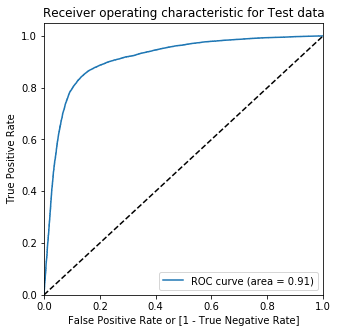

In [133]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

In [134]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Churn  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  \
0    0.0    0.166559          0    1    1    0    0    0    0    0    0    0   
1    0.0    0.001157          0    1    0    0    0    0    0    0    0    0   
2    0.0    0.853777          1    1    1    1    1    1    1    1    1    1   
3    0.0    0.010739          0    1    0    0    0    0    0    0    0    0   
4    0.0    0.381016          0    1    1    1    1    0    0    0    0    0   

   0.9  
0    0  
1    0  
2    0  
3    0  
4    0

In [135]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.707568  0.974582  0.440553
0.2   0.2  0.768346  0.948956  0.587735
0.3   0.3  0.806106  0.921973  0.690240
0.4   0.4  0.834629  0.899843  0.769415
0.5   0.5  0.850365  0.871242  0.829489
0.6   0.6  0.853627  0.831106  0.876148
0.7   0.7  0.837813  0.760282  0.915344
0.8   0.8  0.780689  0.612370  0.949008
0.9   0.9  0.635934  0.292015  0.979854


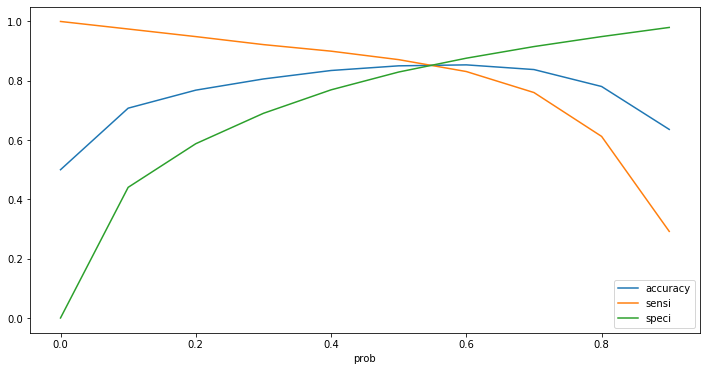

In [136]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

- From the above figure, optimum point is around 0.5 (0.55 approx)
- For a probability cutoff of 0.5, metric scores have already been calculated above
- But according to business intrests, `recall` is our desired metric
- In order to improve the `recall` score, let us try reducing the probability as according to our businees needs, we should reduce `False Negatives`

In [137]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.4 else 0)
print("Training data Metrics")
print("Accuracy:",metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted))
print("Precision:",precision_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted))
print("Recall:",recall_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted))
print(metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted))

Training data Metrics
Accuracy: 0.8346294363256785
Precision: 0.7960201301999169
Recall: 0.8998434237995825
[[14742  4418]
 [ 1919 17241]]


In [138]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.3 else 0)
print("Training data Metrics")
print("Accuracy:",metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted))
print("Precision:",precision_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted))
print("Recall:",recall_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted))
print(metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted))

Training data Metrics
Accuracy: 0.8061064718162839
Precision: 0.7485169491525424
Recall: 0.9219728601252609
[[13225  5935]
 [ 1495 17665]]


### With 0.3 cutoff probability, 92% recall score achieved for test data set

In [139]:
X_test = X_test[col]
X_test.head()

total_og_mou_8  total_ic_mou_8  total_rech_num_8  last_day_rch_amt_8  \
53327       -0.477111       -0.185332         -0.420322            0.871039   
71450        1.406388        2.201137         -0.085248            0.323714   
6087        -0.694169       -0.633967         -0.867087           -0.561664   
56483        0.261377       -0.412826          0.584900           -0.561664   
61884        0.615258        0.662110         -0.085248           -0.722642   

       vol_2g_mb_8  vol_3g_mb_8  monthly_2g_8  sachet_2g_8  monthly_3g_8  \
53327    -0.024935     1.244631      2.099116    -0.421652     -0.345962   
71450    -0.350843    -0.415671     -0.376344    -0.421652     -0.345962   
6087     -0.350843    -0.415671     -0.376344    -0.421652     -0.345962   
56483    -0.350843    -0.415671     -0.376344    -0.421652     -0.345962   
61884    -0.350843    -0.415671     -0.376344    -0.421652     -0.345962   

       sachet_3g_8       aon  vbc_3g_8  last_rech_recency_8  avg_arpu_6_7  \
53327    -0.200574  0.582719 -0.412007             0.908677     -0.451979   
71450    -0.200574 -0.358771 -0.412007            -0.620772      0.118898   
6087     -0.200574 -0.972150 -0.412007             4.349938      0.002471   
56483    -0.200574 -1.025442 -0.412007             0.335134      0.959736   
61884    -0.200574  0.525248 -0.412007            -0.620772     -0.120032   

       avg_roam_ic_mou_6_7  avg_total_og_mou_6_7  avg_total_ic_mou_6_7  \
53327            -0.243583             -0.603635              0.339910   
71450            -0.243583              1.090113              1.525145   
6087             -0.243583              0.582852             -0.619633   
56483            -0.243583              1.819636             -0.603314   
61884            -0.153690              0.741761              0.649579   

       avg_vol_2g_mb_6_7  avg_vol_3g_mb_6_7  avg_monthly_2g_6_7  \
53327          -0.254664           1.420150            2.136429   
71450          -0.432939          -0.460389           -0.462016   
6087           -0.432939          -0.460389           -0.462016   
56483          -0.432939          -0.460389           -0.462016   
61884          -0.432939          -0.460389           -0.462016   

       avg_monthly_3g_6_7  avg_sachet_3g_6_7  
53327           -0.367568          -0.249785  
71450           -0.367568          -0.249785  
6087            -0.367568          -0.249785  
56483           -0.367568          -0.249785  
61884           -0.367568          -0.249785

In [140]:
X_test_sm = sm.add_constant(X_test)
y_test_pred_prob = res.predict(X_test_sm)
y_test_pred_df = pd.DataFrame(y_test_pred_prob)
y_test_pred_df.head()

0
53327  0.046914
71450  0.001734
6087   0.961440
56483  0.703205
61884  0.073471

In [141]:
# Converting y_test to dataframe
y_test_actual_df = pd.DataFrame(y_test)
# Removing index for both dataframes to append them side by side 
y_test_pred_df.reset_index(drop=True, inplace=True)
y_test_actual_df.reset_index(drop=True, inplace=True)
# Appending y_test_pred_df and y_test_actual_df
y_test_pred_final = pd.concat([y_test_actual_df, y_test_pred_df],axis=1)
y_test_pred_final= y_test_pred_final.rename(columns={ 0 : 'Churn_Prob'})
y_test_pred_final.sample(20)

churn  Churn_Prob
8564    0.0    0.217582
4250    0.0    0.590016
4540    0.0    0.025412
2402    1.0    0.741707
4927    0.0    0.850397
352     0.0    0.055923
3089    0.0    0.502531
6802    0.0    0.155772
562     0.0    0.019501
5961    0.0    0.267846
5381    1.0    0.999722
4366    0.0    0.222521
5507    0.0    0.003955
8665    0.0    0.012149
3299    0.0    0.124646
8773    0.0    0.065852
5875    0.0    0.410476
2362    0.0    0.015065
6458    0.0    0.709493
5609    0.0    0.047281

### Using the cutoff probability of 0.3 to increase the recall score

In [142]:
y_test_pred_final['final_predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.3 else 0)

In [143]:
y_test_pred_final.head()

churn  Churn_Prob  final_predicted
0    0.0    0.046914                0
1    0.0    0.001734                0
2    0.0    0.961440                1
3    0.0    0.703205                1
4    0.0    0.073471                0

In [144]:
print(classification_report(y_test_pred_final.churn,y_test_pred_final.final_predicted))
print(confusion_matrix(y_test_pred_final.churn,y_test_pred_final.final_predicted))
print("accuracy", metrics.accuracy_score(y_test_pred_final.churn,y_test_pred_final.final_predicted))
print("precision", metrics.precision_score(y_test_pred_final.churn,y_test_pred_final.final_predicted))
print("sensitivity/recall", metrics.recall_score(y_test_pred_final.churn,y_test_pred_final.final_predicted))

              precision    recall  f1-score   support

         0.0       0.99      0.69      0.81      8212
         1.0       0.22      0.90      0.35       793

    accuracy                           0.71      9005
   macro avg       0.60      0.80      0.58      9005
weighted avg       0.92      0.71      0.77      9005

[[5665 2547]
 [  77  716]]
accuracy 0.7086063298167684
precision 0.21942997241802023
sensitivity/recall 0.9029003783102144


#### Listing down the features influencing the churn based on their adsolute value of coeff in Descending order

In [145]:
body = pd.read_html(res.summary().as_html())[1]
body.columns = ['features', body.iloc[0,1], body.iloc[0,2], body.iloc[0,3], body.iloc[0,4], body.iloc[0,5], body.iloc[0,6]]
coeff = body[1:]
coeff['absValue'] = abs(pd.to_numeric(coeff['coef']))
coeff = coeff.sort_values(by='absValue', ascending=False)
coeff

features     coef std err        z  P>|z|  [0.025  0.975]  \
3         total_ic_mou_8  -2.4897   0.063  -39.735  0.000  -2.612  -2.367   
1                  const  -1.8964   0.028  -68.307  0.000  -1.951  -1.842   
2         total_og_mou_8  -0.8546   0.036  -23.536  0.000  -0.926  -0.783   
18  avg_total_ic_mou_6_7   0.7694   0.039   19.538  0.000   0.692   0.847   
8           monthly_2g_8  -0.5502   0.038  -14.543  0.000  -0.624  -0.476   
6            vol_2g_mb_8  -0.5449   0.044  -12.464  0.000  -0.631  -0.459   
9            sachet_2g_8  -0.5351   0.031  -17.448  0.000  -0.595  -0.475   
5     last_day_rch_amt_8  -0.4926   0.021  -23.061  0.000  -0.534  -0.451   
15          avg_arpu_6_7   0.4014   0.025   15.884  0.000   0.352   0.451   
12                   aon  -0.3688   0.018  -19.947  0.000  -0.405  -0.333   
17  avg_total_og_mou_6_7   0.3570   0.030   11.971  0.000   0.299   0.415   
4       total_rech_num_8  -0.3442   0.025  -13.743  0.000  -0.393  -0.295   
14   last_rech_recency_8   0.3349   0.015   22.149  0.000   0.305   0.365   
10          monthly_3g_8  -0.3194   0.037   -8.579  0.000  -0.392  -0.246   
21    avg_monthly_2g_6_7  -0.2534   0.027   -9.365  0.000  -0.306  -0.200   
19     avg_vol_2g_mb_6_7   0.2160   0.024    9.069  0.000   0.169   0.263   
7            vol_3g_mb_8  -0.2126   0.048   -4.459  0.000  -0.306  -0.119   
16   avg_roam_ic_mou_6_7   0.1986   0.016   12.261  0.000   0.167   0.230   
11           sachet_3g_8  -0.1813   0.033   -5.436  0.000  -0.247  -0.116   
13              vbc_3g_8  -0.1668   0.032   -5.231  0.000  -0.229  -0.104   
23     avg_sachet_3g_6_7   0.1540   0.024    6.412  0.000   0.107   0.201   
22    avg_monthly_3g_6_7   0.0993   0.024    4.088  0.000   0.052   0.147   
20     avg_vol_3g_mb_6_7   0.0216   0.033    0.651  0.515  -0.043   0.086   

    absValue  
3     2.4897  
1     1.8964  
2     0.8546  
18    0.7694  
8     0.5502  
6     0.5449  
9     0.5351  
5     0.4926  
15    0.4014  
12    0.3688  
17    0.3570  
4     0.3442  
14    0.3349  
10    0.3194  
21    0.2534  
19    0.2160  
7     0.2126  
16    0.1986  
11    0.1813  
13    0.1668  
23    0.1540  
22    0.0993  
20    0.0216

In [146]:
col=list(col)
col.append('churn')
df_high_valued[col].head()

total_og_mou_8  total_ic_mou_8  total_rech_num_8  last_day_rch_amt_8  \
0             0.00            5.44               2.0               252.0   
7           350.16          428.74               7.0               779.0   
8           171.56           16.54              14.0                10.0   
16          233.38          294.46               2.0               130.0   
17            0.00            0.00               4.0                 0.0   

    vol_2g_mb_8  vol_3g_mb_8  monthly_2g_8  sachet_2g_8  monthly_3g_8  \
0          5.75       109.61           0.0          0.0           1.0   
7          0.00         0.00           0.0          0.0           0.0   
8          0.03        11.94           0.0          3.0           0.0   
16         0.00         0.00           0.0          0.0           0.0   
17         0.00         0.00           0.0          0.0           0.0   

    sachet_3g_8    aon  vbc_3g_8  last_rech_recency_8  avg_arpu_6_7  \
0           0.0  968.0     30.40                 23.0      206.1005   
7           0.0  802.0     57.74                  5.0     1209.5150   
8           0.0  315.0     21.03                  1.0      435.4720   
16          0.0  511.0      0.00                 17.0      365.4220   
17          0.0  667.0      0.00                  6.0      354.4940   

    avg_roam_ic_mou_6_7  avg_total_og_mou_6_7  avg_total_ic_mou_6_7  \
0                 0.000                 0.000                 0.000   
7                24.860               548.385               592.250   
8                 0.000               470.010                66.175   
16                1.415               316.410               373.210   
17                2.380               625.170                47.095   

    avg_vol_2g_mb_6_7  avg_vol_3g_mb_6_7  avg_monthly_2g_6_7  \
0              15.725            117.165                 0.0   
7               0.000              0.000                 0.0   
8             178.000            375.475                 0.5   
16              0.000              0.000                 0.0   
17              0.000              0.000                 0.0   

    avg_monthly_3g_6_7  avg_sachet_3g_6_7  churn  
0                  1.0                0.0    1.0  
7                  0.0                0.0    1.0  
8                  0.0                0.0    0.0  
16                 0.0                0.0    0.0  
17                 0.0                0.0    0.0

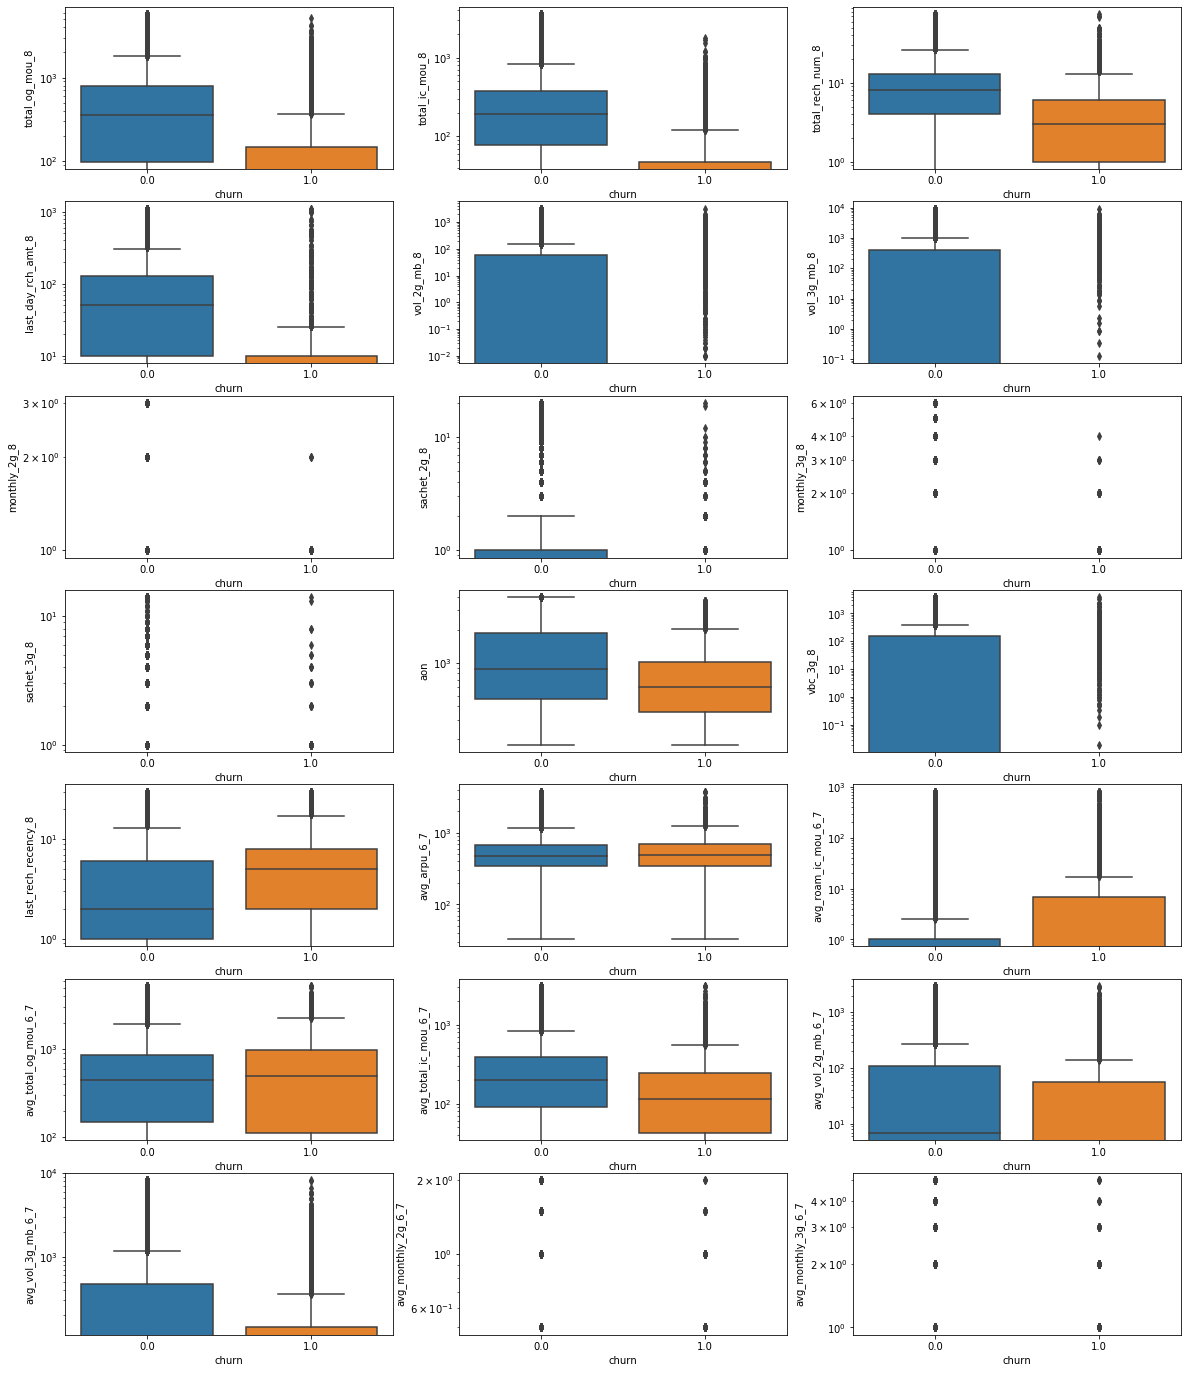

In [147]:
plt.figure(figsize=(20,28))
for count in range(0,len(col)-2):
    plt.subplot(8, 3, count+1)
    sns.boxplot(y=col[count], x='churn', data=df_high_valued)
    plt.yscale('log')
plt.show()

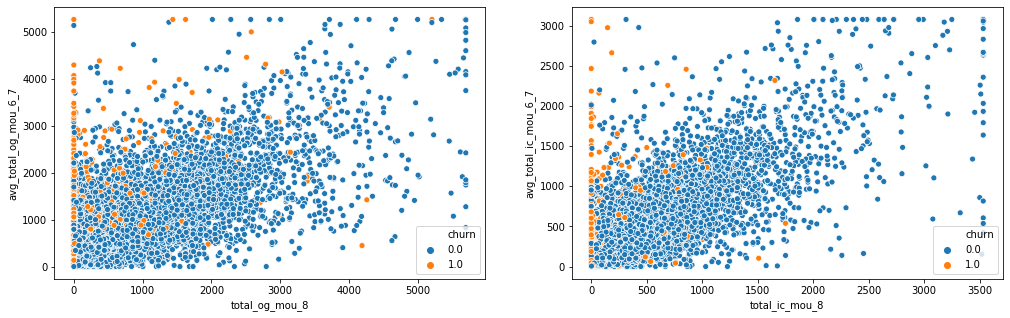

In [148]:
plt.figure(figsize=(17,5))
plt.subplot(121)
sns.scatterplot(x='total_og_mou_8', y='avg_total_og_mou_6_7', hue='churn', data=df_high_valued)
plt.subplot(122)
sns.scatterplot(x='total_ic_mou_8', y='avg_total_ic_mou_6_7', hue='churn', data=df_high_valued)

### Inferences
- Outgoing calls and incoming calls show sharp decline in action phase for churners and non churners compared to good phase
- Reducing count of total recharge numbers in 8th month also indicating churner's trend
- Very less last day recharge amounts give an indication about churners
- Median value for last_rech_recency_8 is less for non churners than churners (To recall, this derived variable "last_rech_recency" gives the diff between the last date of the month and the last recharged date in that month, so lower the value, more the recency)

# Recommendations to the Operator based on the Model Results

1. Roll out offers for Outgoing calls for potential Churn customers like more talk time for churners with less price
2. Provide extra talk time high priced recharges
3. Provide offeres on extra data as well for high priced monthly and sachet recharges for data
4. Introduce catchy small pack recharges for call and data to promote frequency of recharging
5. Introduce specific offers to 3G data and promote some free 2G data as well along with high recharge of 3G data post FUP usage of 3G data